In [119]:
%run dataFormating.ipynb

temporalities set (user answer method)


A Jupyter Widget

A Jupyter Widget

profile info set


A Jupyter Widget

dataFormating.ipynb:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  "outputs": [


In [120]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import scatter_matrix, parallel_coordinates

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import FloatProgress
from IPython.display import display

from math import *

from scipy import stats

# Re-usable functions

In [121]:
# This function counts the number of occurences for each unique element in a list
def get_cnt(lVals):
    d = dict(zip(lVals, [0] * len(lVals)))
    for x in lVals:
        d[x] += 1
    return d

In [122]:
# This function fit a KMeans clustering model on the data, for each number of clusters in a specified range.
# It displays the silhouette analysis plot for each number of clusters and outputs the silhouette scores
# The higher the silhouette score, the more distinct the clusters are. In a good clustering, all clusters raise above the average
# Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def tryKmeans(dataset, rangeNbClusters=[2, 3, 4, 5]):
    results = []
    
    # For each number of clusters
    for n_clusters in rangeNbClusters:
        # Create a subplot with 1 row and 1 column, make it possible to easily add plots in the function later if needed
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        
        # Save the silhouette score, the size of each cluster and the cluster assignement labels
        results.append([n_clusters, silhouette_avg, get_cnt(clusterer.labels_), clusterer.labels_])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
    return results

In [123]:
# This function takes the initial data, result of tryKmeans and a chosen number of clusters
# It returns the label assignements of the sample
# If specified, it plots the parallel coordinates plot
# If specified, display only specified clusters
def detailsKmeans(initData, kmeansResult, nbClusters, displayParallelCoord = False, clusterLabels = [], clustersToDisplay = [], scale = False):
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Displays
    if displayParallelCoord:
        nbGroups = ceil(len(initData.columns) / 8)
        print("Will split columns into {} groups".format(nbGroups))
        progressBar = FloatProgress(value = 0.0, min = 0.0, max = nbGroups)
        display(progressBar)
        # The data is split into several groups of columns for display
        for i in range(nbGroups):
            # Plot the data for the selected columns
            rangeMin = i * 8
            rangeMax = min(len(initData.columns), i * 8 + 9)
            scaledData = initData.iloc[:,rangeMin:rangeMax].copy()
            # Deal with scaling if specified
            if scale:
                col = scaledData.columns
                ind = scaledData.index
                scaledData = preprocessing.scale(scaledData)
                scaledData = pd.DataFrame(data = scaledData, columns=col, index=ind)
            labelledData = pd.concat([scaledData, assignements], axis = 1, join = "inner")
            # Select only some clusters if specified
            if len(clustersToDisplay) > 0:
                labelledData = labelledData.loc[labelledData["Index of cluster"].isin(clustersToDisplay), :]
            fig, ax = plt.subplots()
            fig.set_size_inches(17, 3)
            ax = parallel_coordinates(labelledData, 'Index of cluster')
            
            # Beautification
            plt.xticks(rotation=60)
            if len(clusterLabels) > 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, clusterLabels)
            plt.show()
            
            progressBar.value += 1.0
    
    return assignements

In [124]:
# This function computes the frequency of True answers (scientific questions) or of each possible answer (non-scientific questions) for each cluster of a given clustering
# The specified question can be "allScience" (return table for all scientific questions) or the tag of any question
# If specific question and nbClusters = 2, print t-test between clusters
def freqByCluster(initData, kmeansResult, nbClusters, question) :
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Get the size of the clusters
    sizeOfClusters = kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Size of cluster'][0]
    
    # All scientific questions
    if question == "allScience":
        labelledData = initData.loc[:, "QGenotypePhenotype":"QDevicePbadRbsAraTer"]
        labelledData = pd.concat([labelledData, assignements], axis = 1, join = "inner")
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            answersByCluster[nameOfCluster] = labelledData[labelledData["Index of cluster"] == cluster].sum()
            answersByCluster[nameOfCluster] = answersByCluster[nameOfCluster].divide(sizeOfClusters[cluster])
        answersByCluster.drop("Index of cluster", inplace=True)
    # For a specific question
    else:
        labelledData = pd.concat([initData, assignements], axis = 1, join = "inner")
        labelledData = labelledData.loc[:,[question, "Index of cluster"]]
        if (nbClusters == 2):
            group1 = labelledData[labelledData["Index of cluster"] == 0][question]
            group2 = labelledData[labelledData["Index of cluster"] == 1][question]
            print(stats.ttest_ind(group1, group2))
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            frequencies = labelledData[labelledData["Index of cluster"] == cluster].groupby(question).count()
            frequencies = frequencies.divide(sizeOfClusters[cluster])
            frequencies = pd.DataFrame(data = frequencies["Index of cluster"].values, index = list(frequencies.index), columns = [nameOfCluster])
            answersByCluster = pd.concat([answersByCluster, frequencies], axis=1)
        answersByCluster.fillna(value = 0, inplace = True)
        
    return answersByCluster


# Can the data be clustered according to the answers given to the before questionnaire?

## If scientific questions are coded by answers

In [125]:
pd.options.display.max_columns = None
beforeForms["QEnjoyed"].unique()

array([0, -1, 4, 3, 1, 2], dtype=object)

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


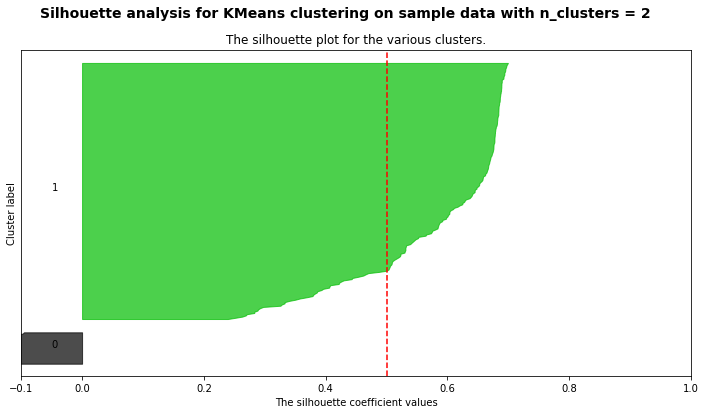

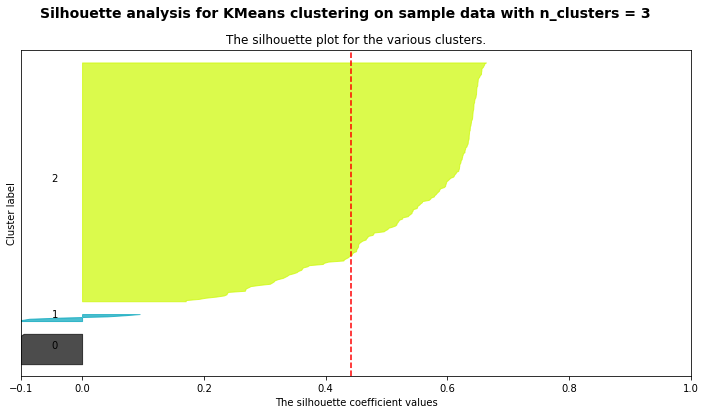

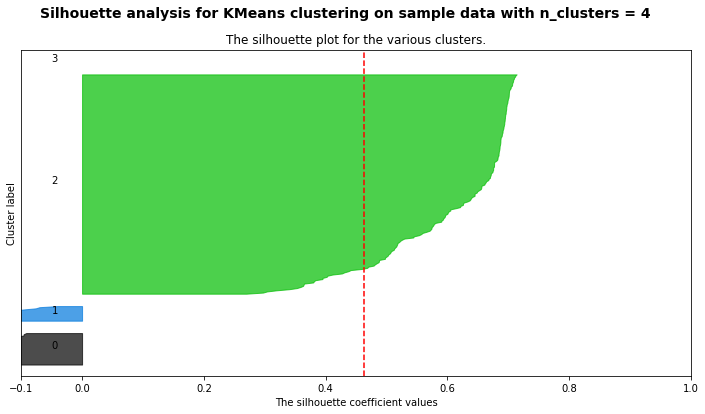

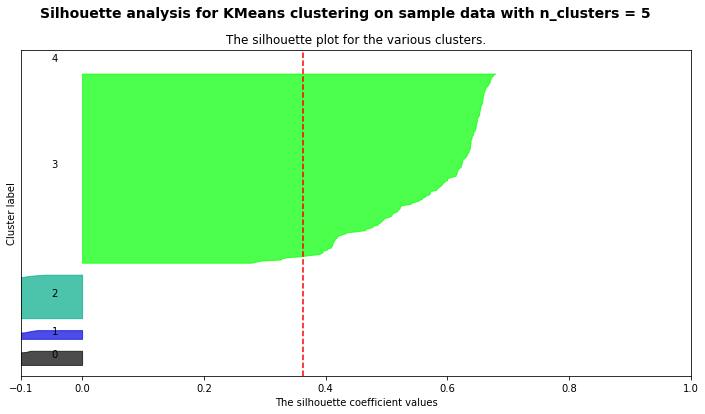

Number of clusters  Average silhouette score  \
0                   2                  0.500343   
1                   3                  0.441119   
2                   4                  0.462334   
3                   5                  0.362923   

                      Size of cluster  \
0                     {1: 213, 0: 27}   
1               {2: 206, 1: 7, 0: 27}   
2        {2: 196, 0: 29, 3: 1, 1: 14}   
3  {2: 41, 3: 175, 1: 9, 0: 14, 4: 1}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, ...  
2  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, ...  
3  [2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, ...

In [126]:
# Convert DataFrame to matrix
beforeMat = beforeForms.as_matrix()
# Standardise data
beforeMat = preprocessing.scale(beforeMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeResults = tryKmeans(beforeMat)
# Format results as a DataFrame
beforeResults = pd.DataFrame(data=beforeResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


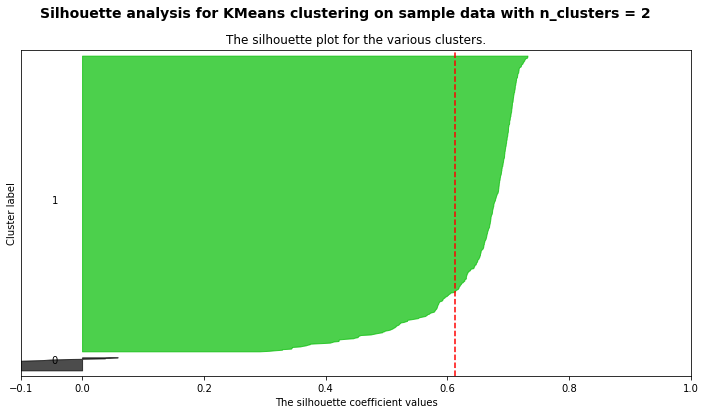

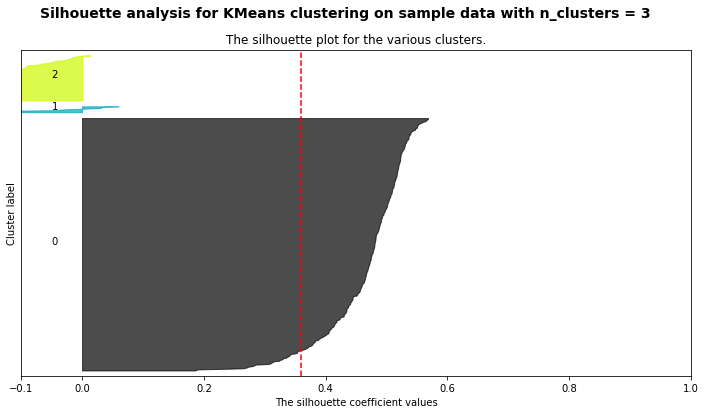

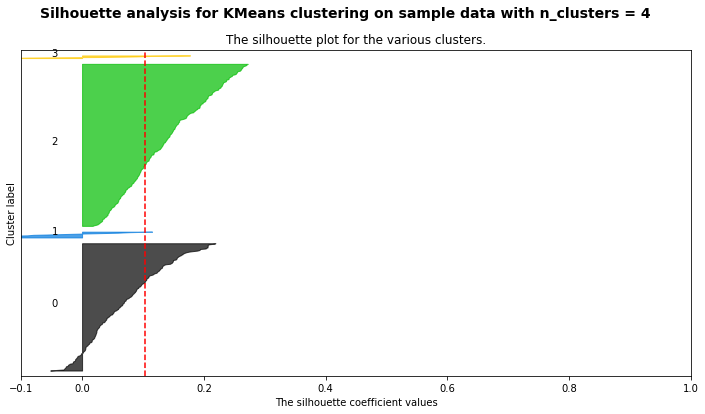

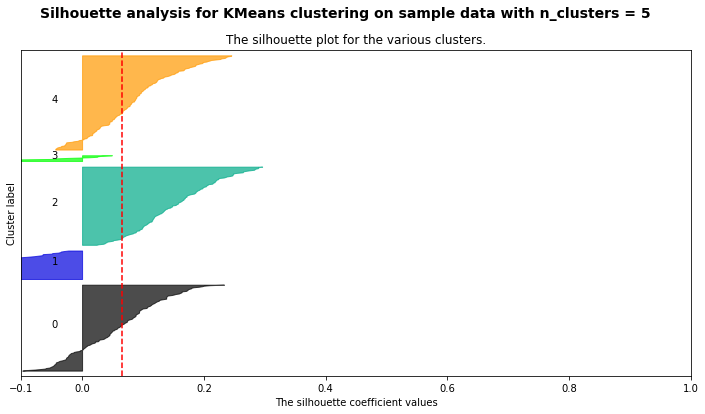

Number of clusters  Average silhouette score  \
0                   2                  0.612419   
1                   3                  0.359757   
2                   4                  0.103047   
3                   5                  0.065593   

                          Size of cluster  \
0                         {1: 545, 0: 25}   
1                  {0: 473, 2: 85, 1: 12}   
2           {0: 243, 2: 309, 3: 6, 1: 12}   
3  {0: 167, 2: 152, 1: 56, 4: 183, 3: 12}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, ...  
2  [0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, ...  
3  [0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0, 2, 4, ...

In [127]:
# Convert DataFrame to matrix
beforeCorrectedMat = beforeCorrectedForms.as_matrix()
# Standardise data
beforeCorrectedMat = preprocessing.scale(beforeCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeCorrectedResults = tryKmeans(beforeCorrectedMat)
# Format results as a DataFrame
beforeCorrectedResults = pd.DataFrame(data=beforeCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeCorrectedResults

Conclusion: No interesting clustering (29/05/2018)

Will split columns into 6 groups


A Jupyter Widget

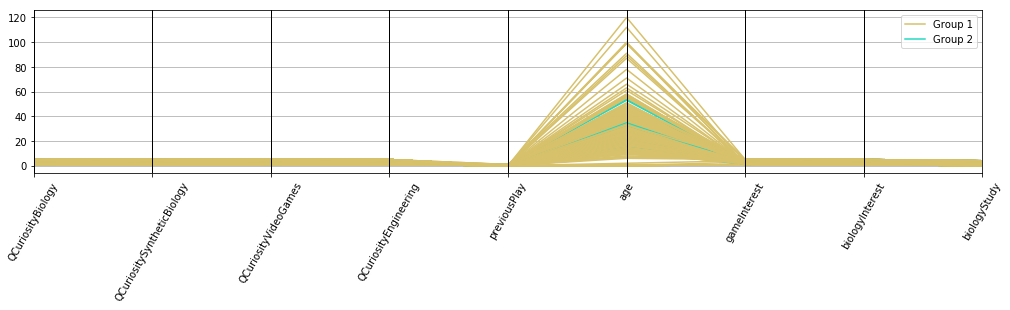

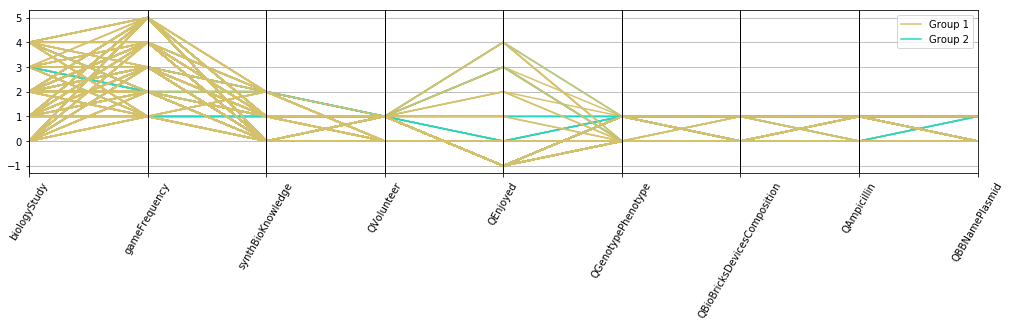

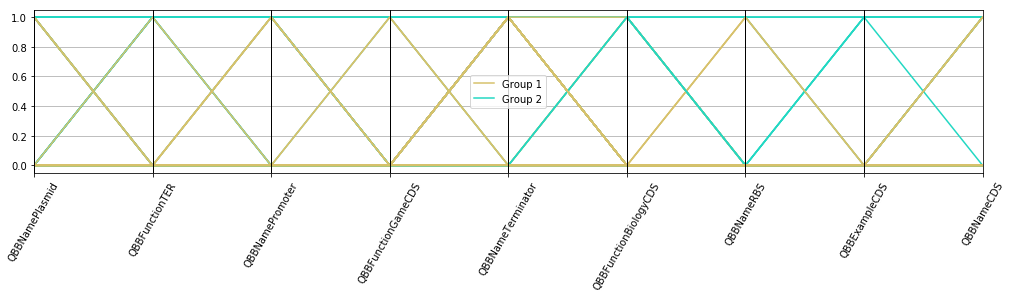

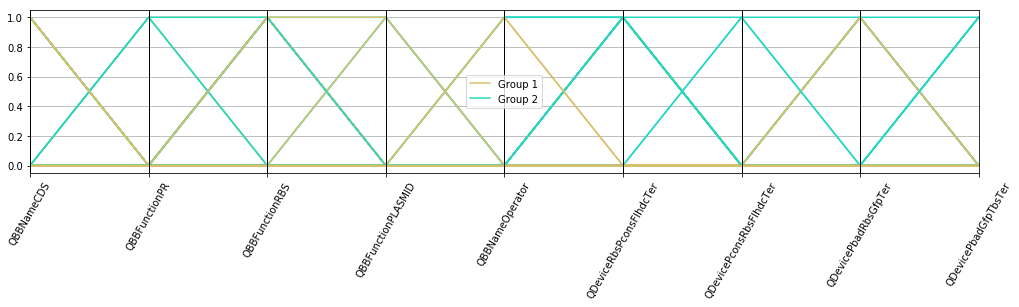

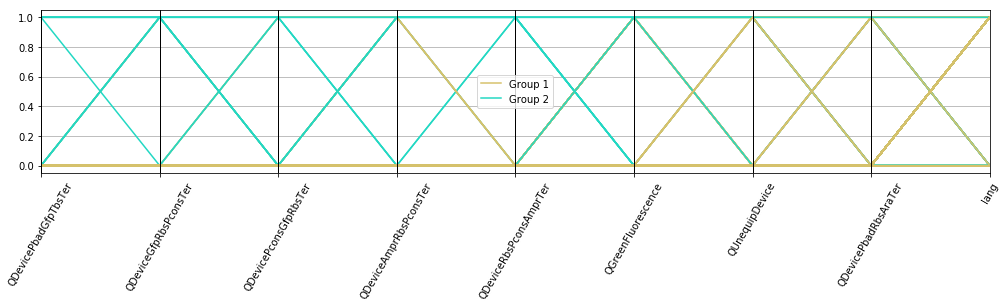

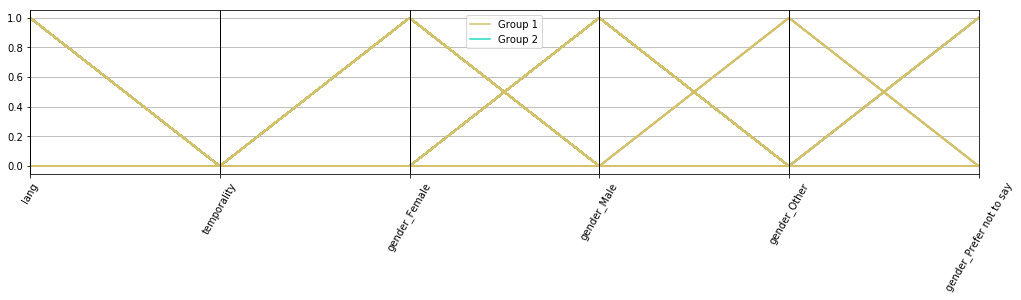

In [128]:
# Display parallel coordinates plot
assignements = detailsKmeans(beforeCorrectedForms, beforeCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

# Can the data be clustered according to the answers given to the after questionnaire?

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


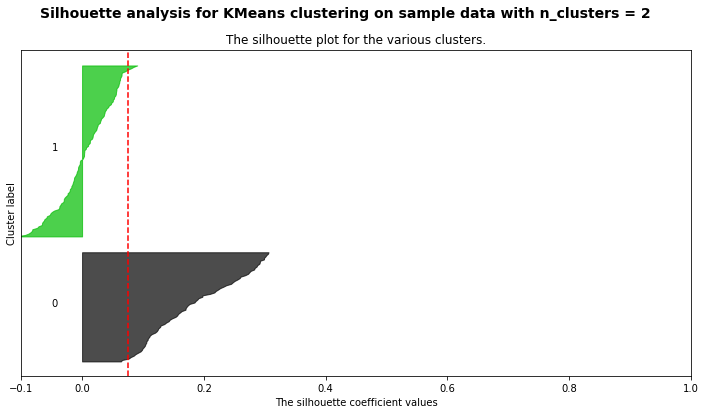

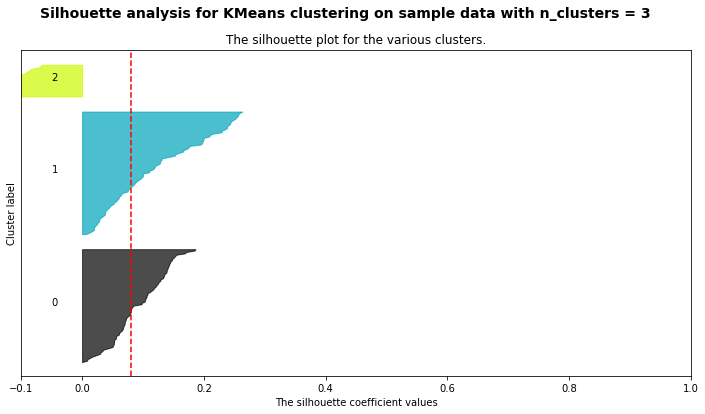

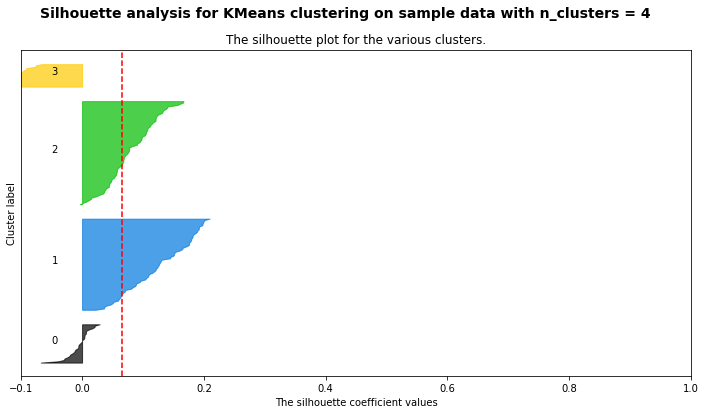

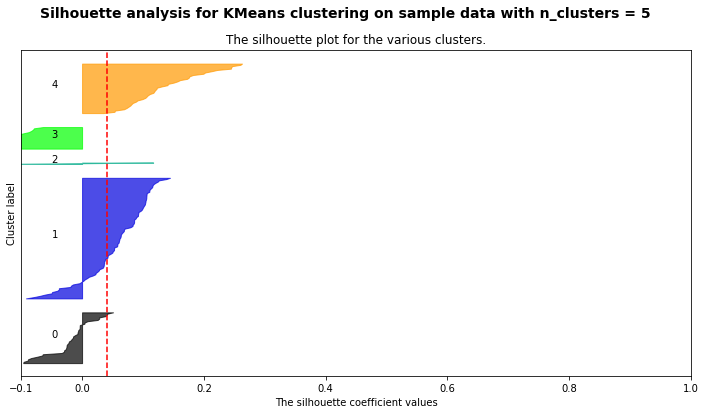

In [129]:
# Convert DataFrame to matrix
afterMat = afterForms.as_matrix()
# Standardise the data
afterMat = preprocessing.scale(afterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterResults = tryKmeans(afterMat)
# Format results as a DataFrame
afterResults = pd.DataFrame(data=afterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


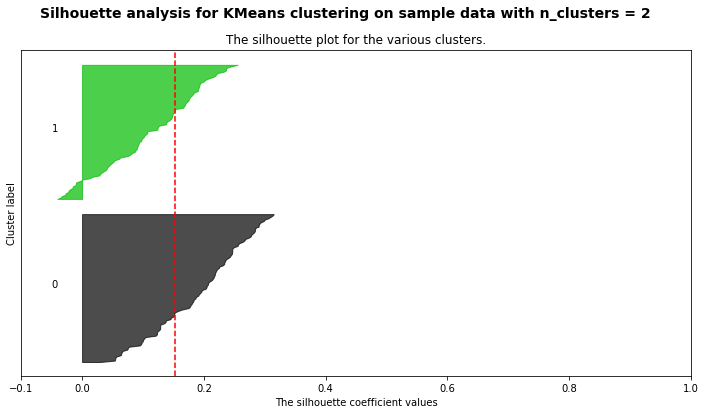

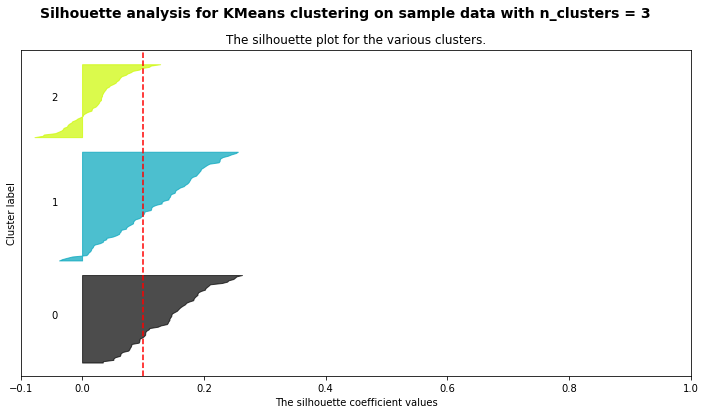

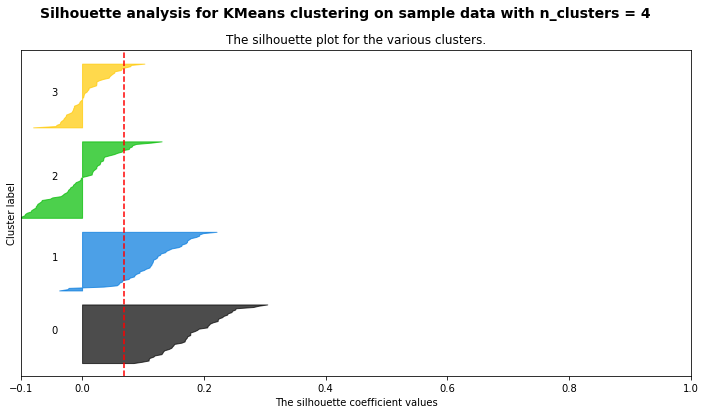

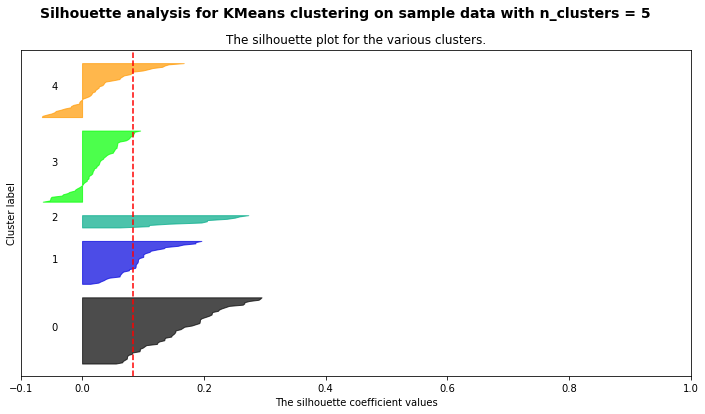

Number of clusters  Average silhouette score  \
0                   2                  0.152414   
1                   3                  0.099844   
2                   4                  0.069007   
3                   5                  0.083340   

                       Size of cluster  \
0                      {1: 98, 0: 108}   
1                {1: 83, 2: 56, 0: 67}   
2         {3: 51, 1: 47, 2: 61, 0: 47}   
3  {1: 36, 2: 11, 0: 55, 3: 59, 4: 45}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
1  [1, 1, 2, 1, 1, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, ...  
2  [3, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 3, 2, 2, 3, ...  
3  [1, 1, 2, 1, 1, 1, 0, 3, 0, 2, 3, 4, 4, 4, 3, ...

In [130]:
# Convert DataFrame to matrix
afterCorrectedMat = afterCorrectedForms.as_matrix()
# Standardise the data
afterCorrectedMat = preprocessing.scale(afterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterCorrectedResults = tryKmeans(afterCorrectedMat)
# Format results as a DataFrame
afterCorrectedResults = pd.DataFrame(data=afterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
afterCorrectedResults

Will split columns into 6 groups


A Jupyter Widget

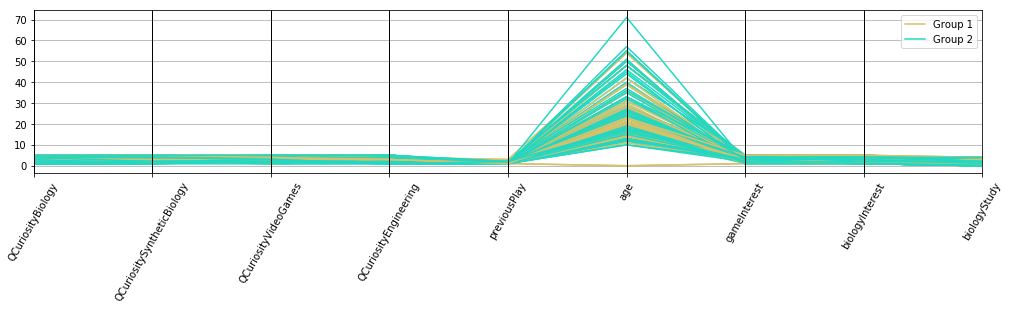

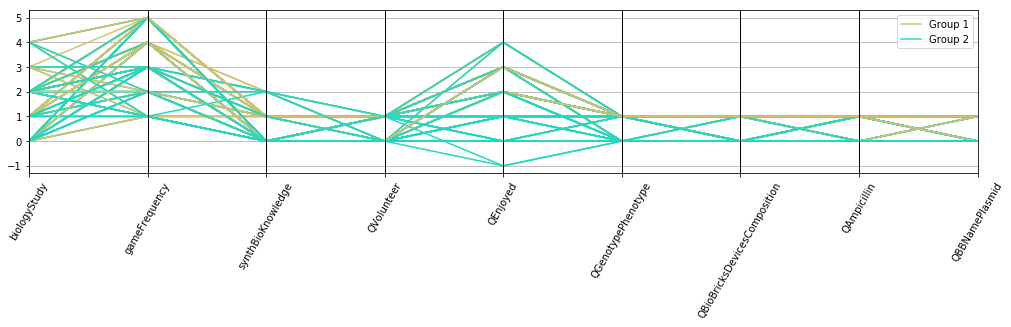

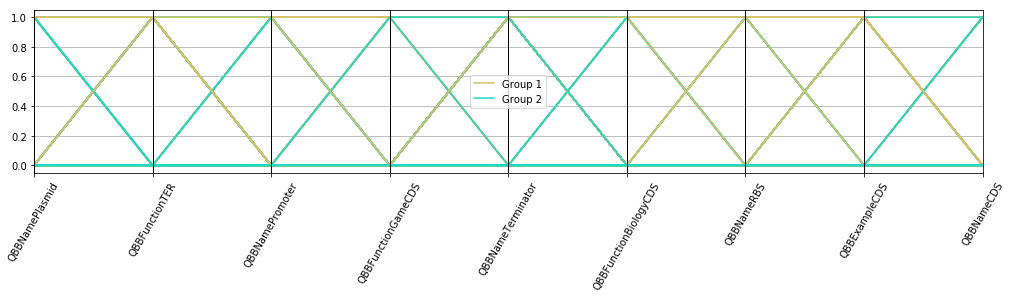

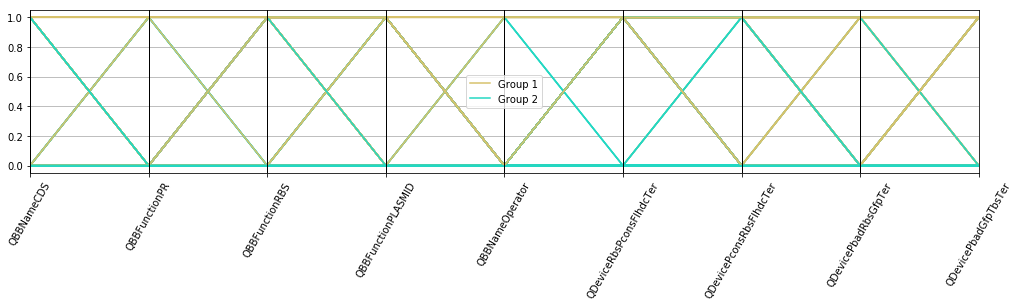

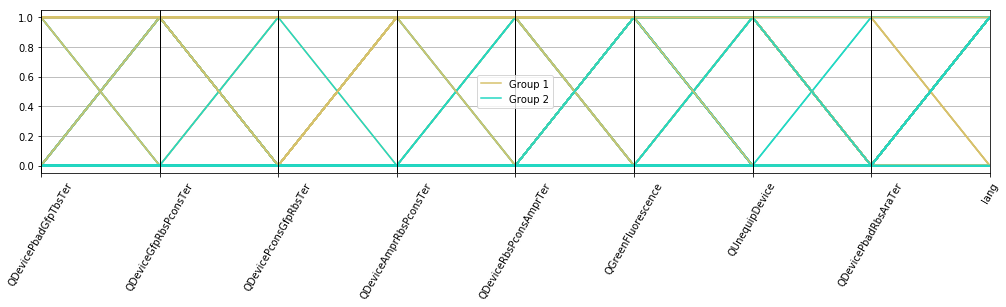

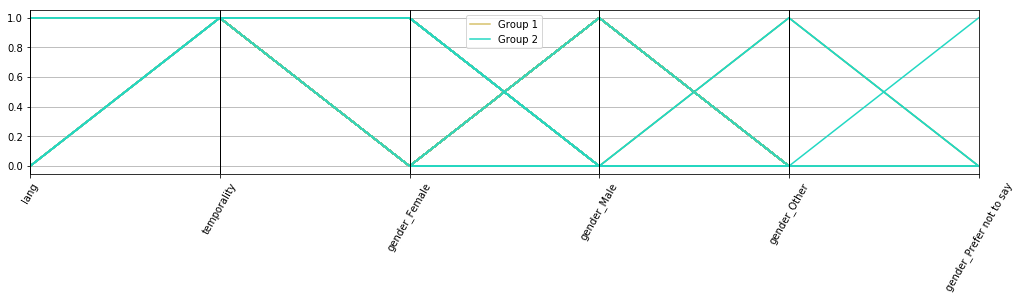

In [131]:
# Display parallel coordinates plot
assignements = detailsKmeans(afterCorrectedForms, afterCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

In [132]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "allScience")
correctAnswersByCluster

Cluster 0  Cluster 1
QGenotypePhenotype                 0.64   0.121101
QBioBricksDevicesComposition       0.28   0.038532
QAmpicillin                        0.56   0.137615
QBBNamePlasmid                     0.36   0.020183
QBBFunctionTER                     0.52   0.005505
QBBNamePromoter                    0.44   0.011009
QBBFunctionGameCDS                 0.16   0.005505
QBBNameTerminator                  0.60   0.053211
QBBFunctionBiologyCDS              0.40   0.007339
QBBNameRBS                         0.12   0.005505
QBBExampleCDS                      0.24   0.000000
QBBNameCDS                         0.36   0.014679
QBBFunctionPR                      0.12   0.003670
QBBFunctionRBS                     0.36   0.018349
QBBFunctionPLASMID                 0.12   0.003670
QBBNameOperator                    0.12   0.003670
QDeviceRbsPconsFlhdcTer            0.60   0.009174
QDevicePconsRbsFlhdcTer            0.12   0.000000
QDevicePbadRbsGfpTer               0.24   0.005505
QDevicePbadGfpTbsTer               0.24   0.000000
QDeviceGfpRbsPconsTer              0.44   0.001835
QDevicePconsGfpRbsTer              0.28   0.001835
QDeviceAmprRbsPconsTer             0.44   0.007339
QDeviceRbsPconsAmprTer             0.44   0.000000
QGreenFluorescence                 0.44   0.042202
QUnequipDevice                     0.32   0.033028
QDevicePbadRbsAraTer               0.32   0.029358

In [133]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=10.179107786508432, pvalue=5.610738140791271e-14)

In [134]:
# Compute frequency of different levels of biology study for each group and each question
biologyStudyPerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "biologyStudy")
biologyStudyPerCluster

Ttest_indResult(statistic=2.001684918663606, pvalue=0.04579373859402968)


Cluster 0  Cluster 1
0       0.12   0.201835
1       0.16   0.209174
2       0.32   0.383486
3       0.20   0.095413
4       0.20   0.110092

In [135]:
# Compute frequency of different levels of synthBioKnowledge for each group and each question
synthBioKnowledgePerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "synthBioKnowledge")
synthBioKnowledgePerCluster

Ttest_indResult(statistic=2.7452478330023213, pvalue=0.006237955769862188)


Cluster 0  Cluster 1
0       0.44   0.594495
1       0.24   0.310092
2       0.32   0.095413

In [136]:
# Compute score and compare clusters
afterCorrectedForms["sum"] = afterCorrectedForms.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(afterCorrectedForms, afterCorrectedResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=-23.484947891487355, pvalue=6.516426014461605e-60)


Cluster 0  Cluster 1
0.0    0.138889   0.000000
1.0    0.092593   0.000000
2.0    0.111111   0.000000
3.0    0.074074   0.000000
4.0    0.120370   0.000000
5.0    0.111111   0.000000
6.0    0.101852   0.000000
7.0    0.101852   0.000000
8.0    0.055556   0.000000
9.0    0.037037   0.051020
10.0   0.037037   0.040816
11.0   0.009259   0.051020
12.0   0.009259   0.091837
13.0   0.000000   0.112245
14.0   0.000000   0.081633
15.0   0.000000   0.071429
16.0   0.000000   0.081633
17.0   0.000000   0.071429
18.0   0.000000   0.112245
19.0   0.000000   0.081633
20.0   0.000000   0.061224
21.0   0.000000   0.030612
22.0   0.000000   0.020408
23.0   0.000000   0.020408
26.0   0.000000   0.010204
27.0   0.000000   0.010204

Conclusion: Two clusters, one with slightly higher level of biology Study and synthetic biology previous knowledge, and much higher scores. See above for details of questions. (29/05/18)

# Can the data be clustered according to the answers given to the questionnaire?

## If scientific questions are coded by answers

### If only before and after questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


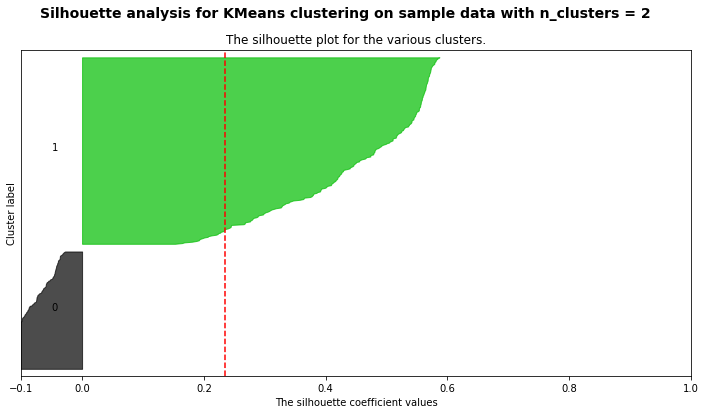

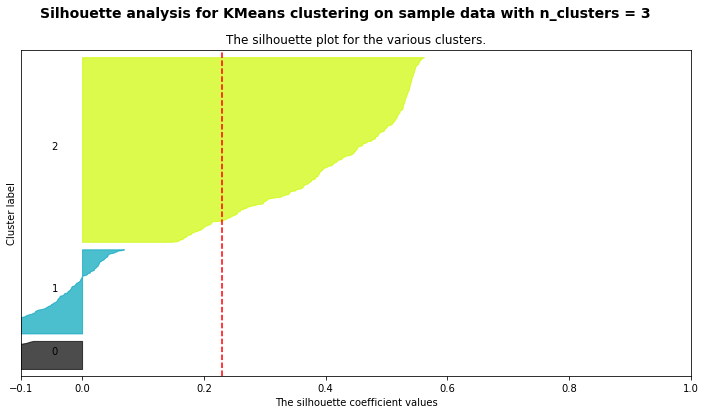

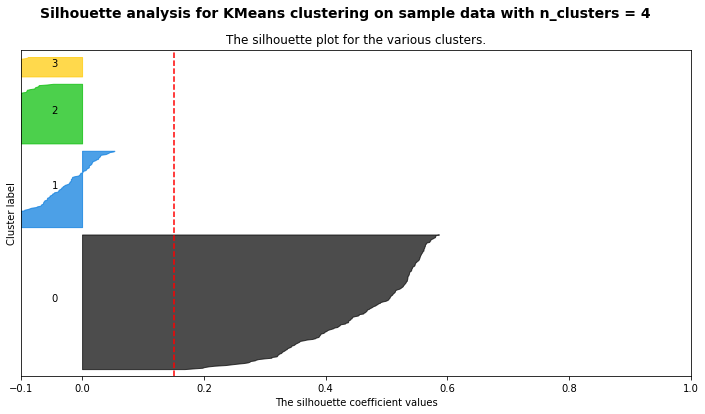

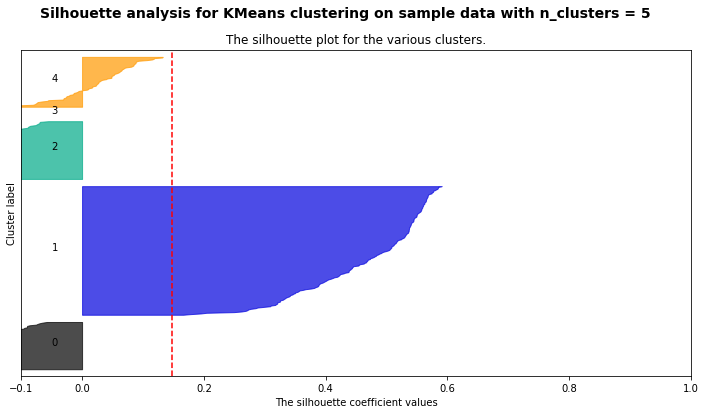

Number of clusters  Average silhouette score  \
0                   2                  0.234557   
1                   3                  0.230422   
2                   4                  0.150237   
3                   5                  0.147038   

                       Size of cluster  \
0                     {1: 268, 0: 169}   
1              {2: 271, 1: 124, 0: 42}   
2       {2: 90, 1: 115, 0: 202, 3: 30}   
3  {2: 89, 4: 77, 1: 197, 0: 73, 3: 1}   

                                  Label assignements  
0  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
1  [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...  
2  [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, ...  
3  [2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 4, ...

In [137]:
# Convert DataFrame to matrix
defMat = defForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defMat = preprocessing.scale(defMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defResults = tryKmeans(defMat)
# Format results as a DataFrame
defResults = pd.DataFrame(data=defResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


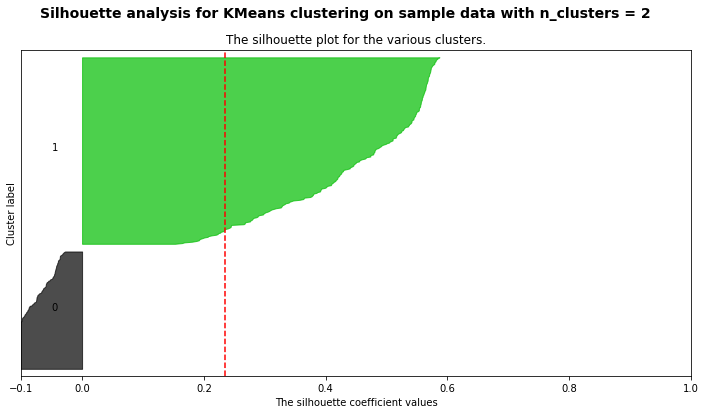

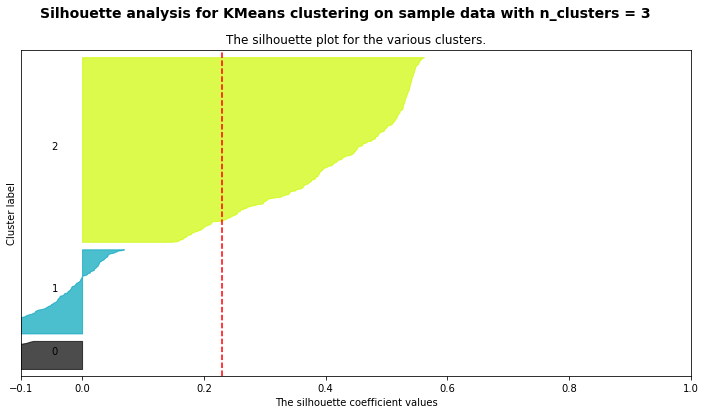

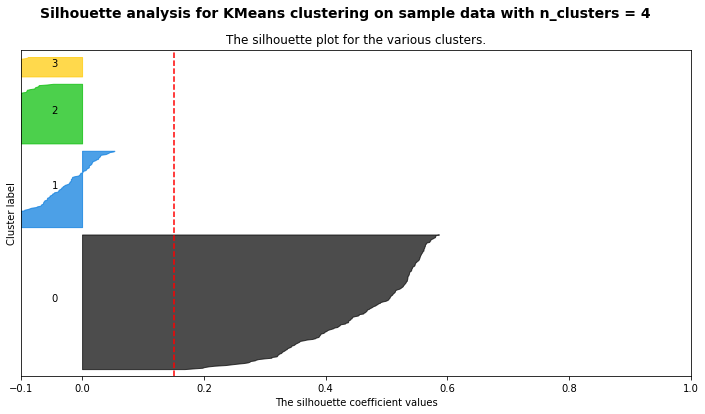

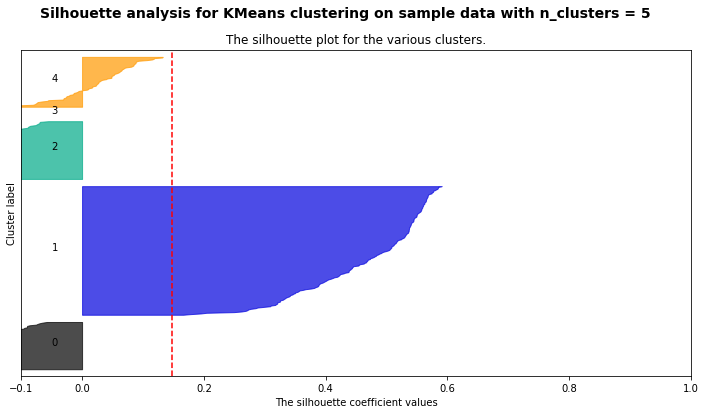

Number of clusters  Average silhouette score  \
0                   2                  0.234557   
1                   3                  0.230422   
2                   4                  0.150237   
3                   5                  0.147038   

                       Size of cluster  \
0                     {1: 268, 0: 169}   
1              {2: 271, 1: 124, 0: 42}   
2       {2: 90, 1: 115, 0: 202, 3: 30}   
3  {2: 89, 4: 77, 1: 197, 0: 73, 3: 1}   

                                  Label assignements  
0  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
1  [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...  
2  [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, ...  
3  [2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 4, ...

In [138]:
# Convert DataFrame to matrix
allMat = allForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allMat = preprocessing.scale(allMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allResults = tryKmeans(allMat)
# Format results as a DataFrame
allResults = pd.DataFrame(data=allResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allResults

Conclusion: No interesting clustering (16/01/2018)

In [139]:
assignements = detailsKmeans(allForms, allResults, 2)
assignements = pd.concat([assignements, allForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted before", "Predicted after"], index = ["Actual after", "Actual before"])
defConfusionMat

Predicted before  Predicted after
Actual after                 27              213
Actual before               142               55

## If scientific questions are coded by correctedness

### If only before and after questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


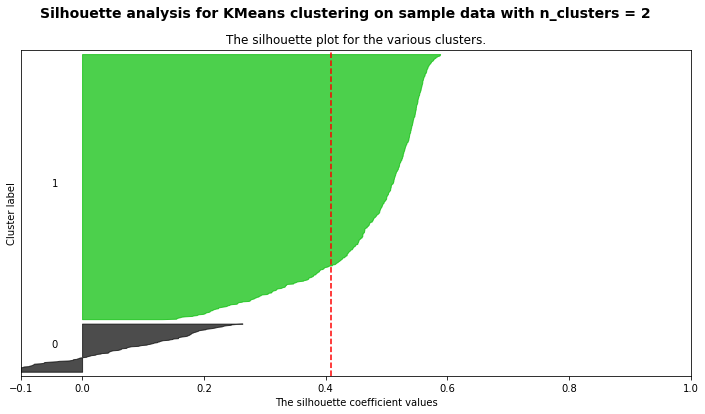

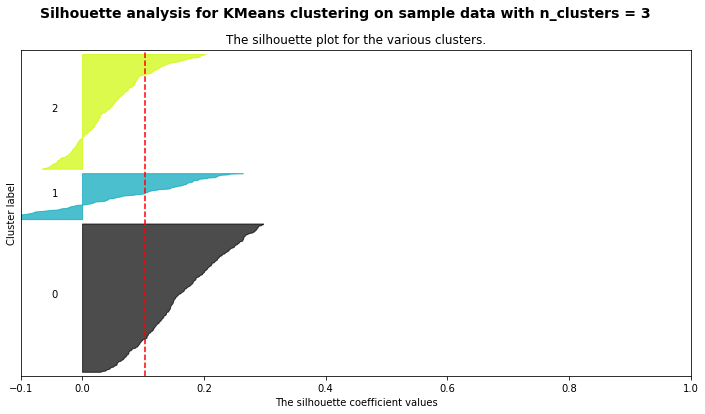

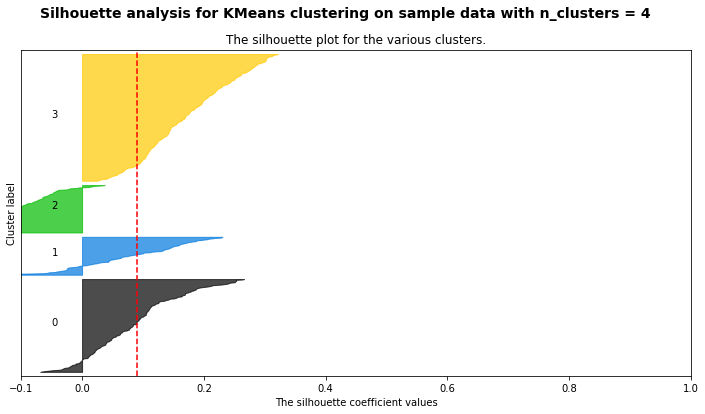

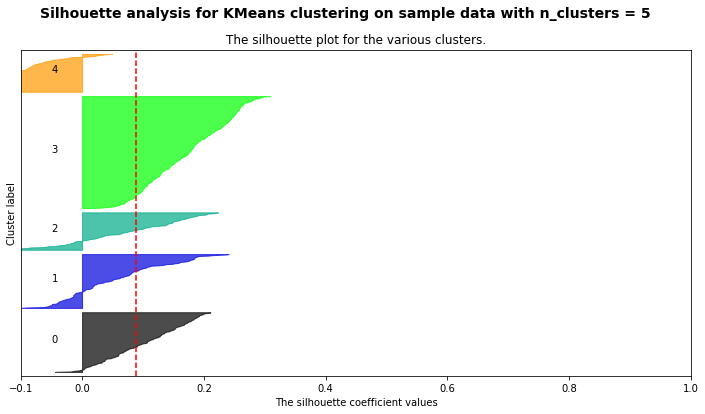

Number of clusters  Average silhouette score  \
0                   2                  0.408470   
1                   3                  0.104195   
2                   4                  0.089897   
3                   5                  0.088816   

                          Size of cluster  \
0                        {1: 656, 0: 120}   
1                {2: 288, 0: 372, 1: 116}   
2         {0: 236, 3: 322, 2: 121, 1: 97}   
3  {1: 139, 3: 288, 0: 154, 4: 98, 2: 97}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, ...  
2  [0, 0, 3, 3, 3, 3, 0, 3, 2, 2, 0, 0, 0, 3, 3, ...  
3  [1, 1, 3, 3, 3, 3, 0, 1, 4, 4, 1, 1, 0, 3, 3, ...

In [141]:
# Convert DataFrame to matrix
defCorrectedMat = defCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defCorrectedMat = preprocessing.scale(defCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defCorrectedResults = tryKmeans(defCorrectedMat)
# Format results as a DataFrame
defCorrectedResults = pd.DataFrame(data=defCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defCorrectedResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


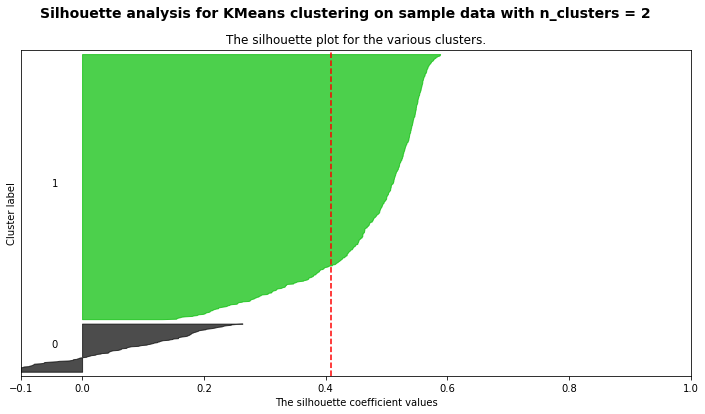

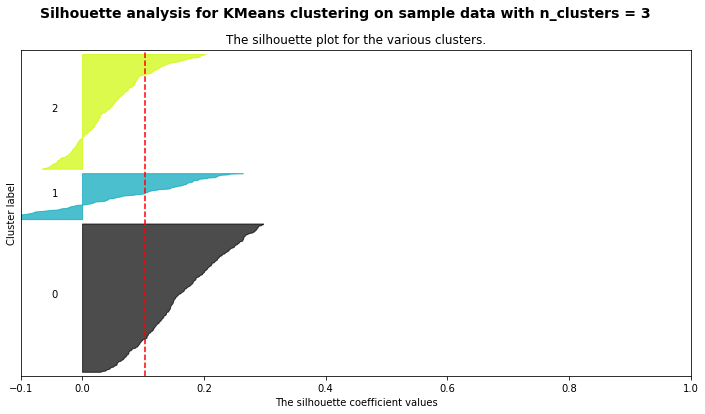

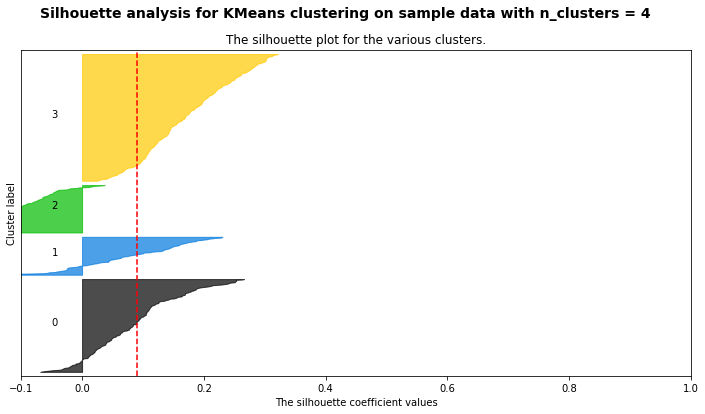

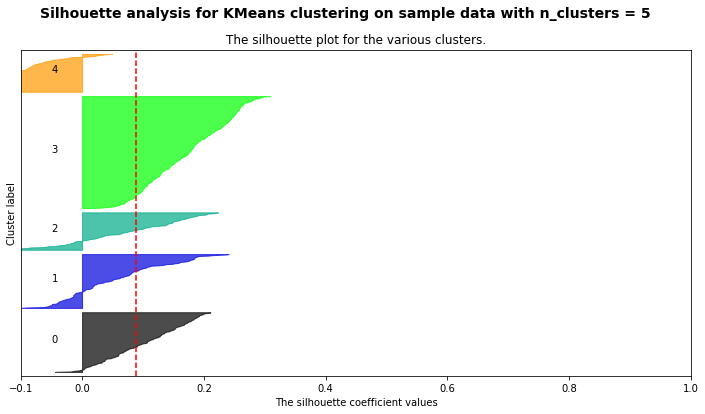

Number of clusters  Average silhouette score  \
0                   2                  0.408470   
1                   3                  0.104195   
2                   4                  0.089897   
3                   5                  0.088816   

                          Size of cluster  \
0                        {1: 656, 0: 120}   
1                {2: 288, 0: 372, 1: 116}   
2         {0: 236, 3: 322, 2: 121, 1: 97}   
3  {1: 139, 3: 288, 0: 154, 4: 98, 2: 97}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, ...  
2  [0, 0, 3, 3, 3, 3, 0, 3, 2, 2, 0, 0, 0, 3, 3, ...  
3  [1, 1, 3, 3, 3, 3, 0, 1, 4, 4, 1, 1, 0, 3, 3, ...

In [143]:
# Convert DataFrame to matrix
allCorrectedMat = allCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allCorrectedMat = preprocessing.scale(allCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allCorrectedResults = tryKmeans(allCorrectedMat)
# Format results as a DataFrame
allCorrectedResults = pd.DataFrame(data=allCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allCorrectedResults

Conclusion: No interesting clustering (29/05/18)

# Can the data be clustered according to the answers given to both the before and the after questionnaire?

# TODO! Rethink meaning of this section with new experiment

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


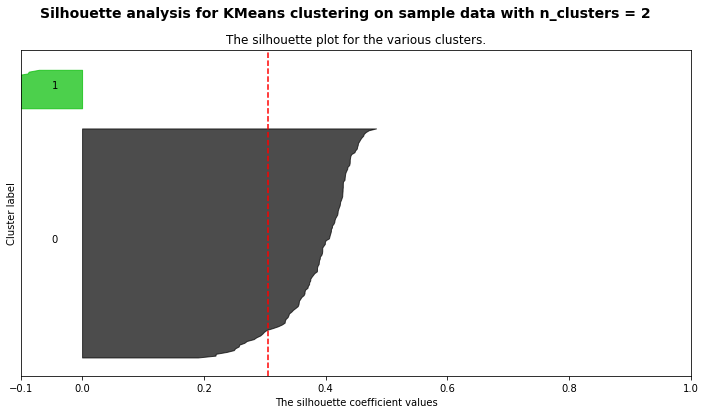

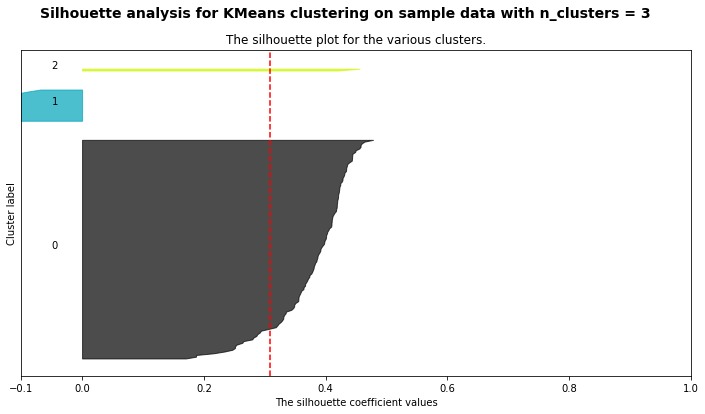

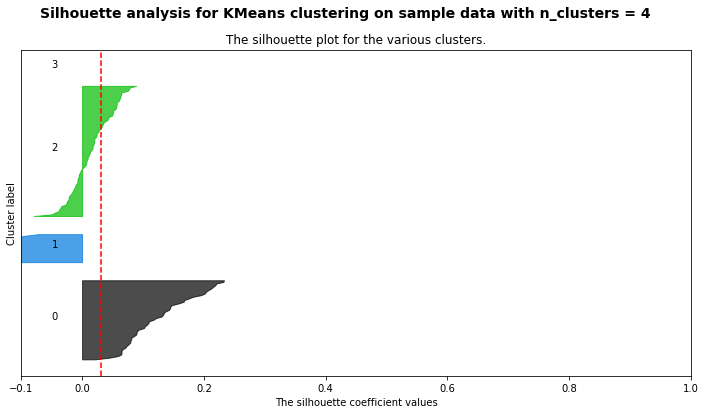

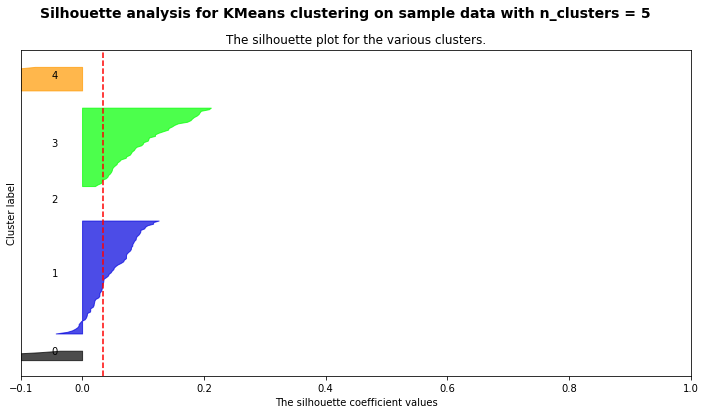

Number of clusters  Average silhouette score  \
0                   2                  0.305166   
1                   3                  0.309265   
2                   4                  0.031143   
3                   5                  0.033765   

                     Size of cluster  \
0                    {1: 22, 0: 126}   
1              {1: 19, 0: 127, 2: 2}   
2        {1: 18, 2: 80, 0: 49, 3: 1}   
3  {1: 73, 4: 16, 0: 7, 3: 51, 2: 1}   

                                  Label assignements  
0  [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...  
1  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...  
2  [1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 4, 0, 3, 4, 0, 1, 1, ...

In [145]:
# Convert DataFrame to matrix
beforeAndAfterMat = beforeAndAfterForms.as_matrix()
# Standardise the data
beforeAndAfterMat = preprocessing.scale(beforeAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterResults = tryKmeans(beforeAndAfterMat)
# Format results as a DataFrame
beforeAndAfterResults = pd.DataFrame(data=beforeAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


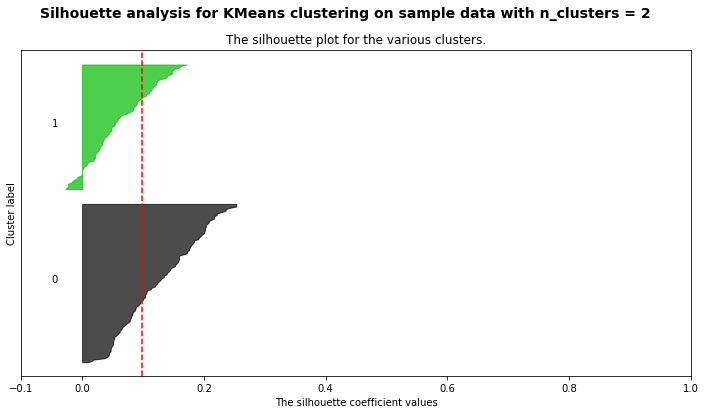

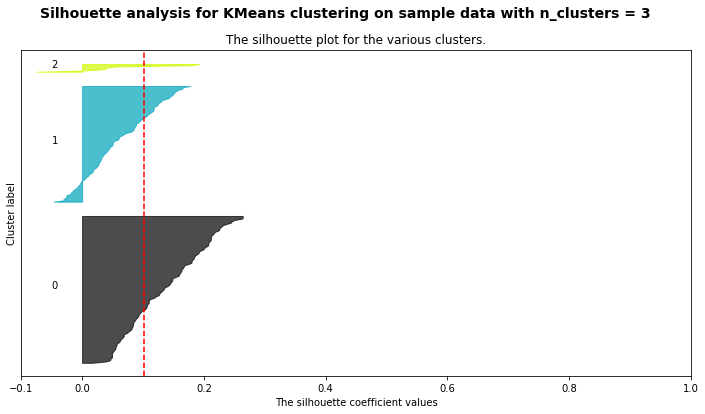

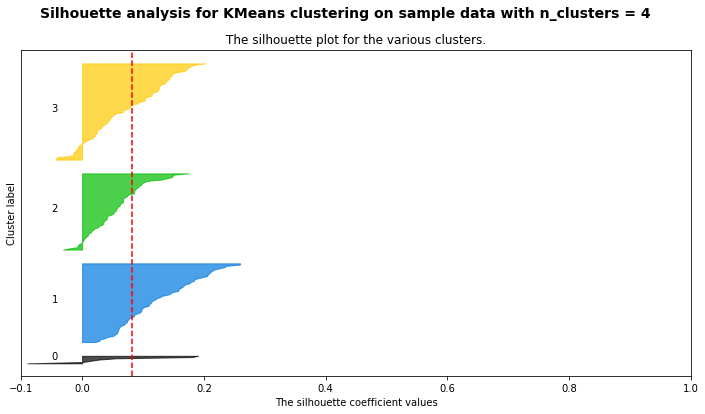

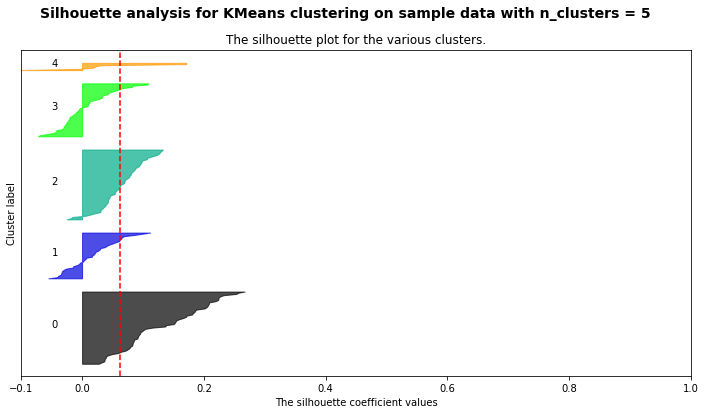

Number of clusters  Average silhouette score  \
0                   2                  0.097883   
1                   3                  0.101441   
2                   4                  0.082029   
3                   5                  0.062192   

                      Size of cluster  \
0                     {1: 93, 0: 118}   
1               {1: 90, 0: 114, 2: 7}   
2         {3: 78, 2: 62, 1: 64, 0: 7}   
3  {1: 39, 3: 45, 0: 61, 4: 7, 2: 59}   

                                  Label assignements  
0  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...  
1  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...  
2  [3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, ...  
3  [1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 0, 3, 3, ...

In [146]:
# Convert DataFrame to matrix
beforeAndAfterCorrectedMat = beforeAndAfterCorrectedForms.as_matrix()
# Standardise the data
beforeAndAfterCorrectedMat = preprocessing.scale(beforeAndAfterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterCorrectedResults = tryKmeans(beforeAndAfterCorrectedMat)
# Format results as a DataFrame
beforeAndAfterCorrectedResults = pd.DataFrame(data=beforeAndAfterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterCorrectedResults

Conclusion: The data could be clustered in two groups (29/05/18)

Will split columns into 12 groups


A Jupyter Widget

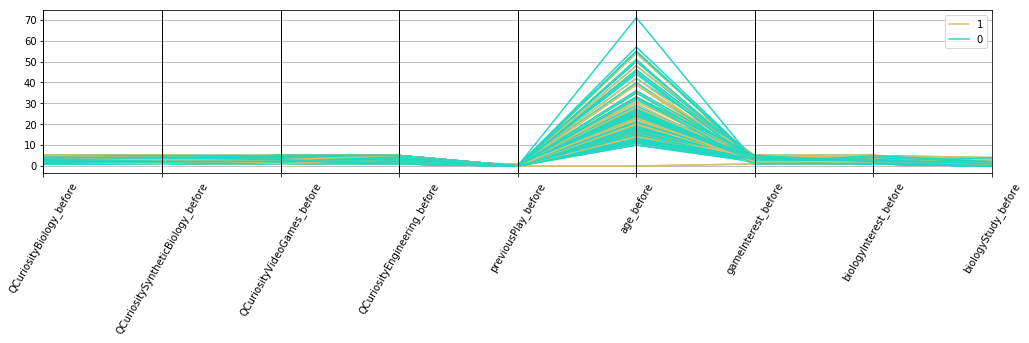

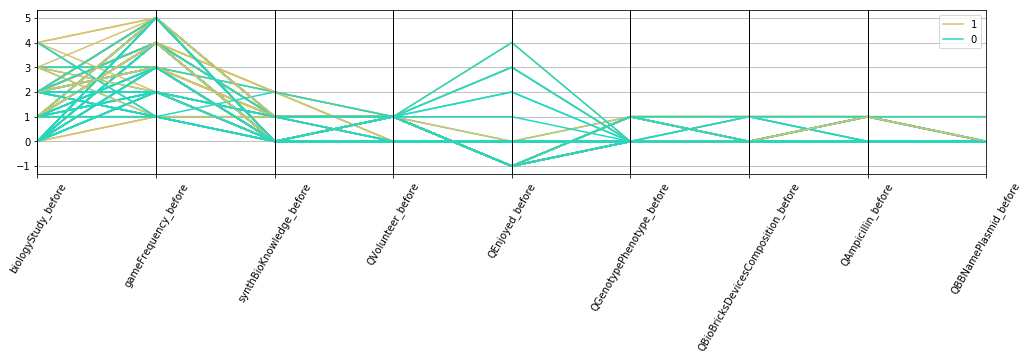

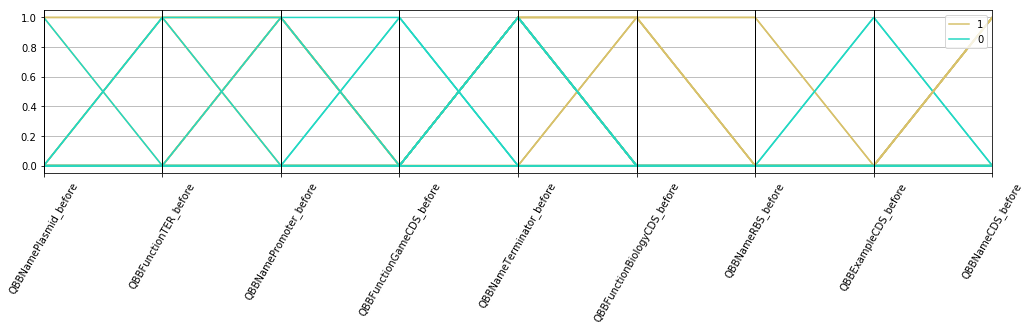

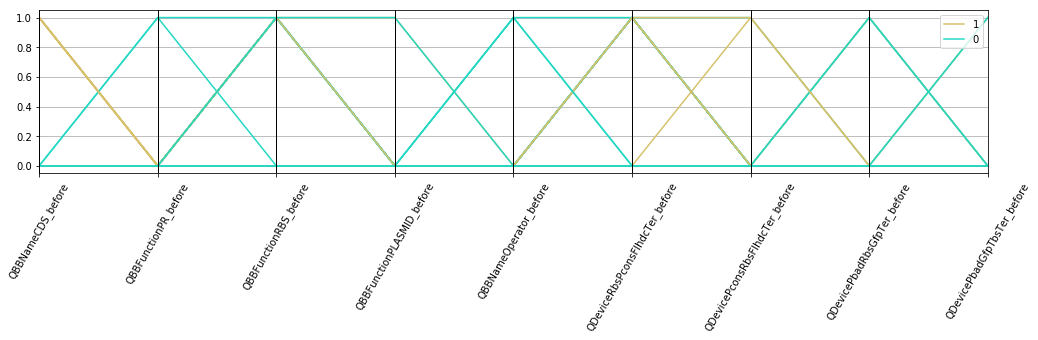

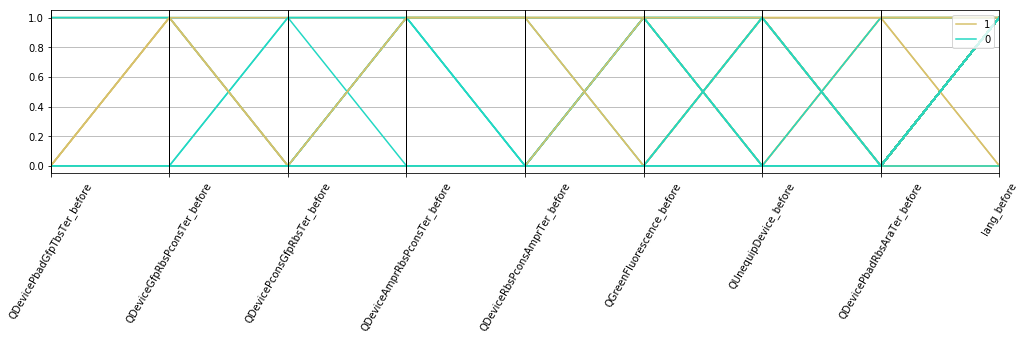

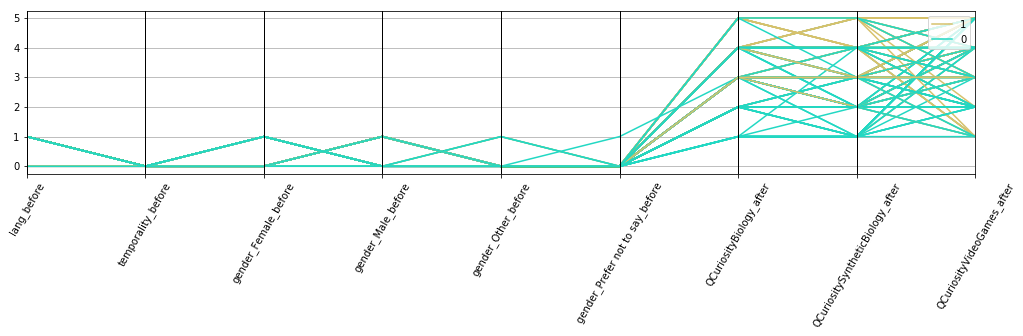

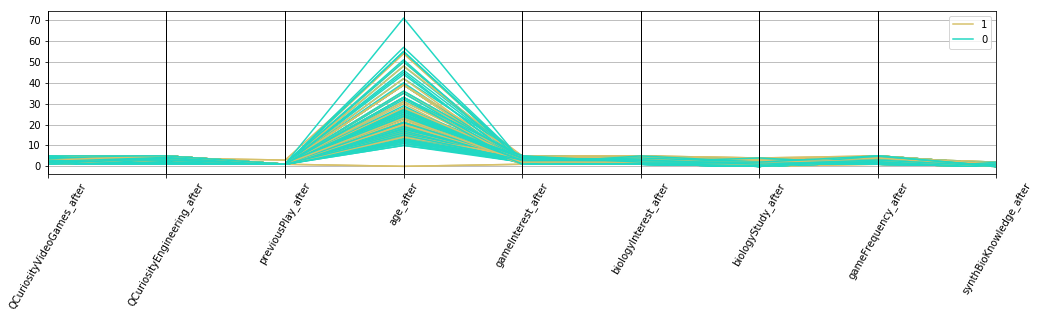

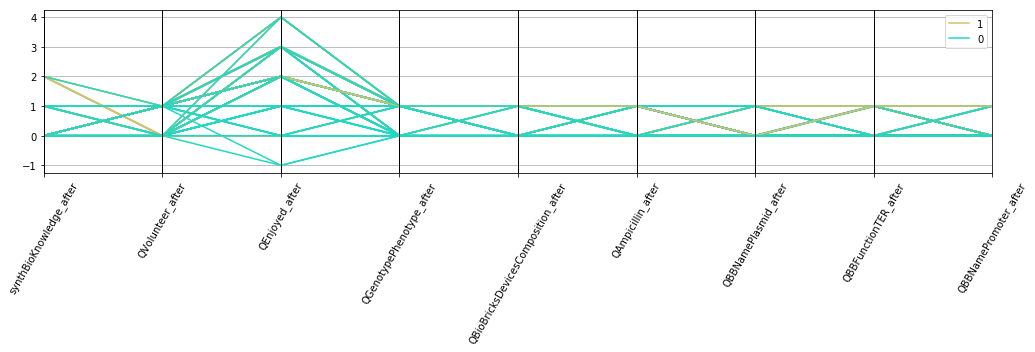

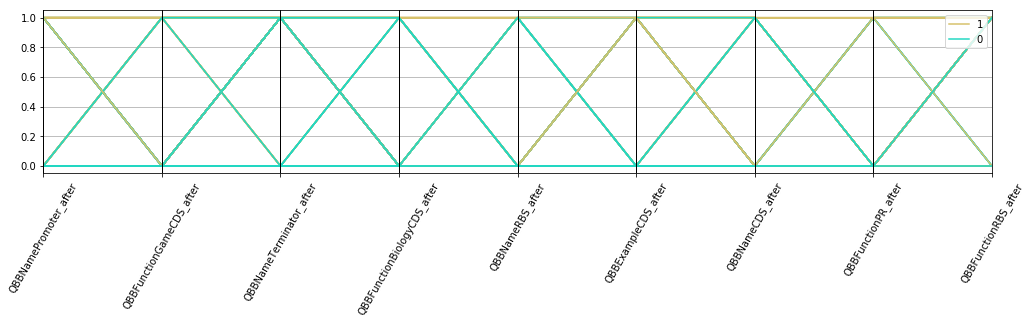

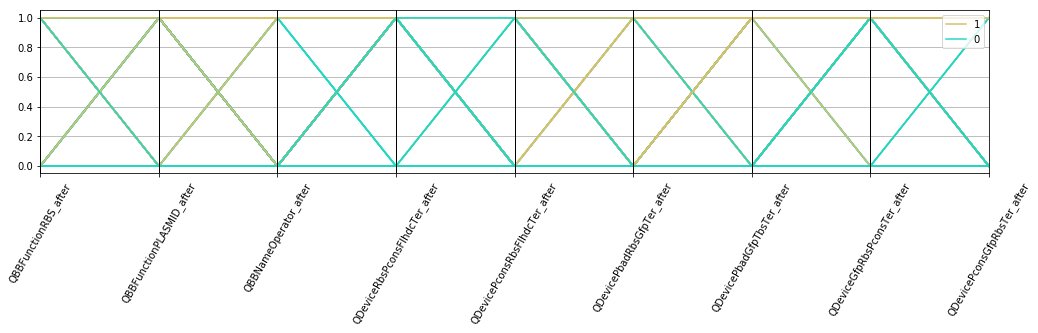

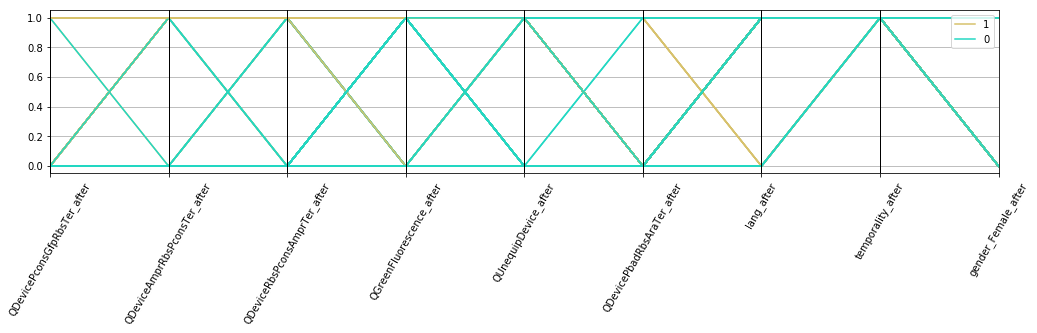

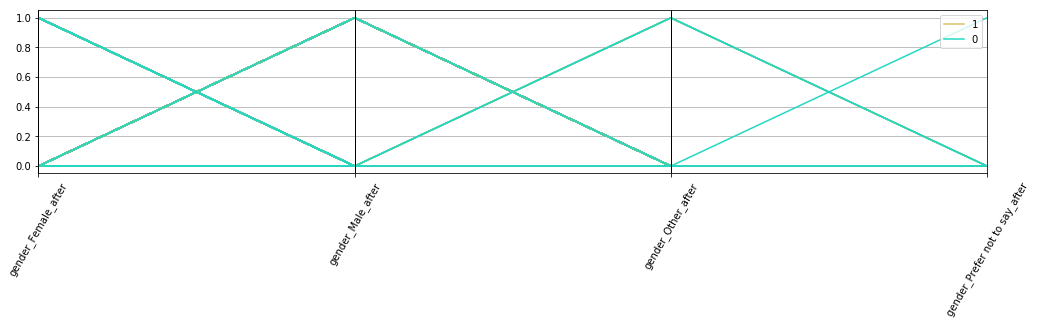

In [147]:
assignements = detailsKmeans(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, displayParallelCoord=True)

In [148]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "previousPlay_before")
correctAnswersByCluster

Ttest_indResult(statistic=-0.1687610121414964, pvalue=0.8661478377288953)


Cluster 0  Cluster 1
0   0.991525   0.989247
1   0.008475   0.010753

In [149]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_before")
correctAnswersByCluster

Ttest_indResult(statistic=-5.287722570392816, pvalue=3.111245598906272e-07)


Cluster 0  Cluster 1
1   0.220339   0.043011
2   0.245763   0.150538
3   0.364407   0.430108
4   0.135593   0.215054
5   0.033898   0.161290

In [150]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyStudy_before")
correctAnswersByCluster

Ttest_indResult(statistic=-4.347285970310735, pvalue=2.1520598176238662e-05)


Cluster 0  Cluster 1
0   0.355932   0.129032
1   0.262712   0.225806
2   0.330508   0.526882
3   0.033898   0.075269
4   0.016949   0.043011

In [151]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_after")
correctAnswersByCluster

Ttest_indResult(statistic=-4.764232546798563, pvalue=3.5440307019867004e-06)


Cluster 0  Cluster 1
1   0.203390   0.032258
2   0.254237   0.150538
3   0.330508   0.408602
4   0.135593   0.236559
5   0.076271   0.172043

TODO Raphael: Look in details at scientific questions

# Can the data be clustered according to the RedMetrics values?

## All sessions

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


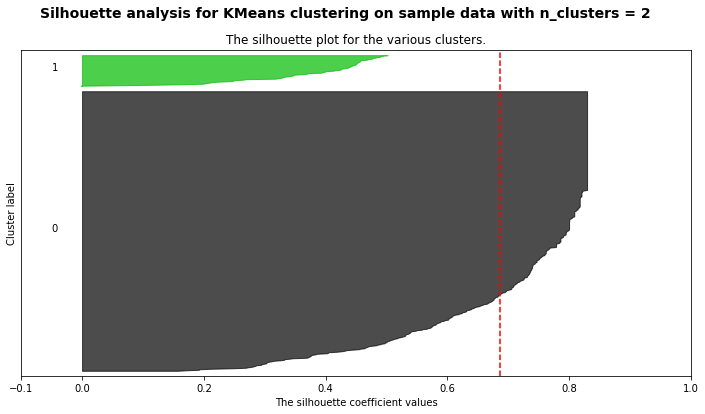

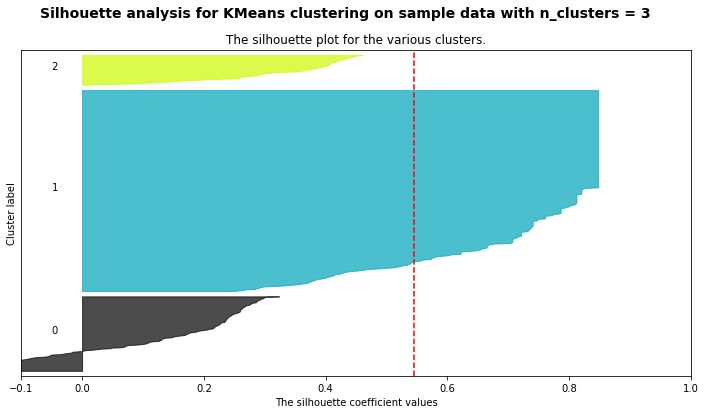

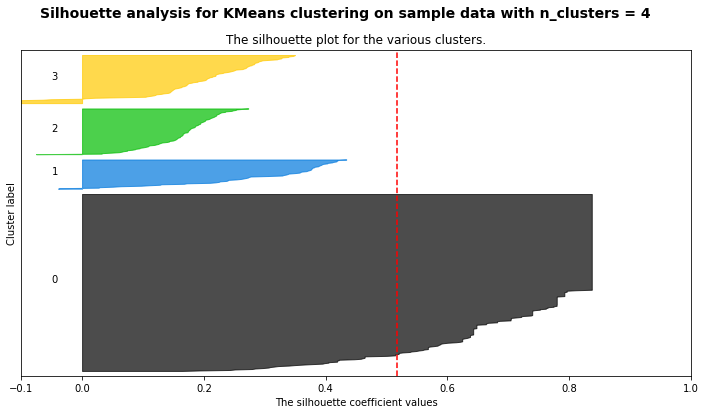

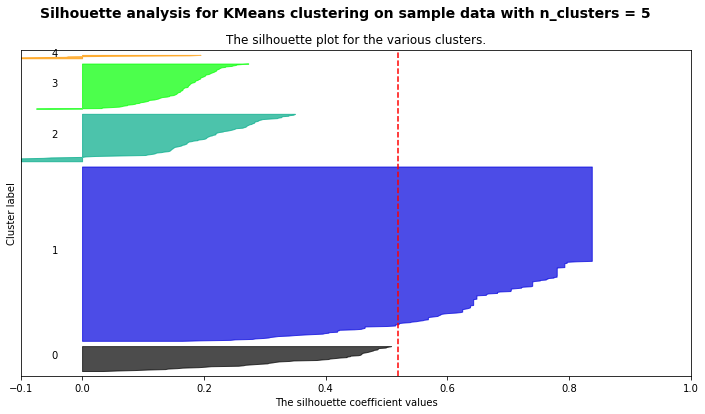

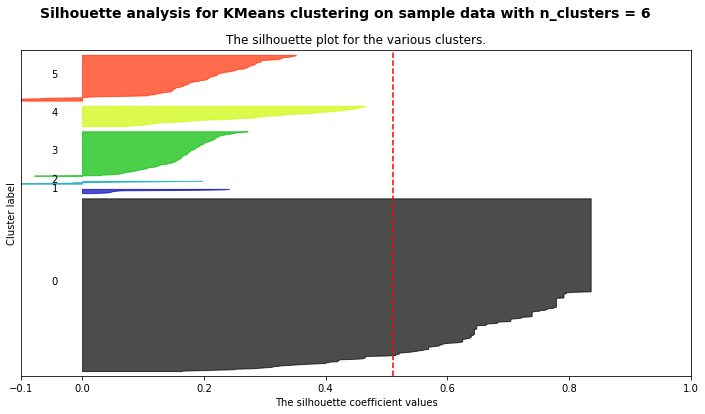

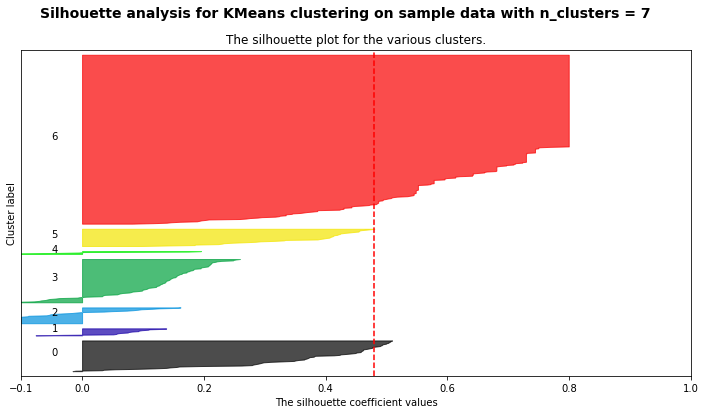

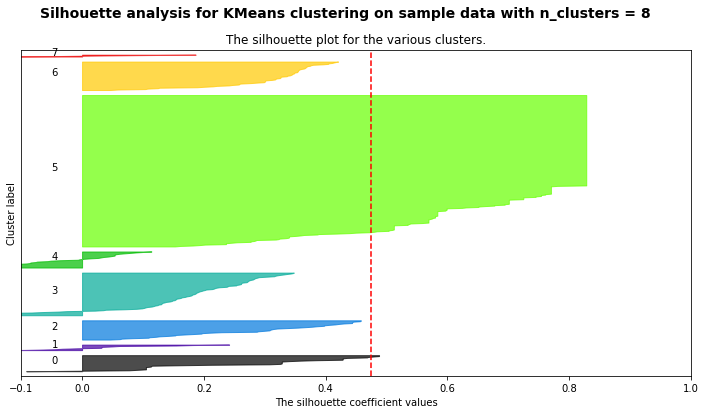

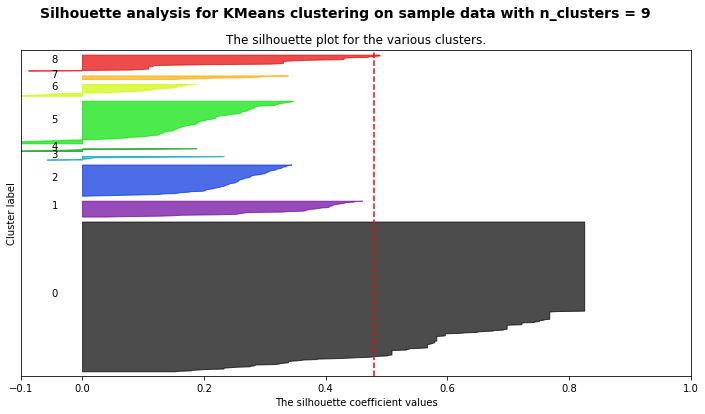

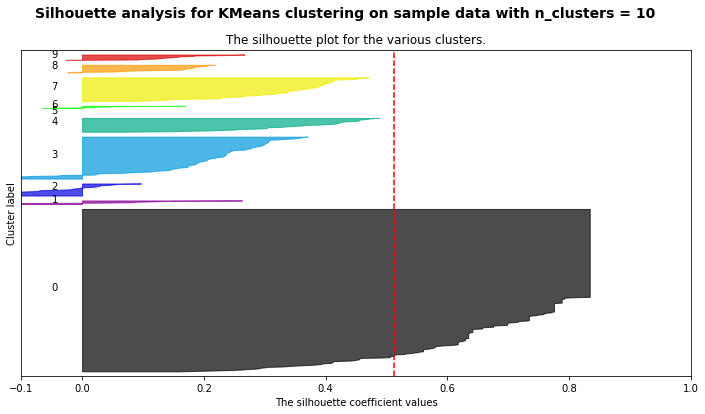

Number of clusters  Average silhouette score  \
0                   2                  0.685945   
1                   3                  0.545622   
2                   4                  0.516860   
3                   5                  0.518742   
4                   6                  0.511277   
5                   7                  0.479750   
6                   8                  0.475343   
7                   9                  0.479796   
8                  10                  0.512951   

                                     Size of cluster  \
0                                    {0: 559, 1: 62}   
1                            {1: 408, 0: 152, 2: 61}   
2                     {0: 365, 3: 100, 1: 61, 2: 95}   
3               {1: 365, 2: 100, 0: 53, 3: 95, 4: 8}   
4         {0: 367, 5: 98, 4: 44, 3: 95, 2: 7, 1: 10}   
5  {6: 364, 0: 67, 5: 38, 3: 94, 2: 35, 4: 7, 1: 16}   
6  {5: 331, 3: 94, 2: 43, 6: 63, 0: 36, 4: 36, 7:...   
7  {0: 332, 5: 95, 1: 36, 8: 36, 6: 27, 2: 70, 4:...   
8  {0: 365, 3: 95, 4: 32, 7: 54, 8: 18, 5: 1, 6: ...   

                                  Label assignements  
0  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, ...  
2  [0, 0, 0, 3, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0, ...  
3  [1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, ...  
4  [0, 0, 0, 5, 0, 5, 4, 0, 5, 5, 0, 0, 0, 0, 0, ...  
5  [6, 6, 6, 0, 6, 0, 5, 6, 0, 0, 6, 6, 6, 6, 6, ...  
6  [5, 5, 5, 3, 5, 3, 2, 5, 3, 6, 0, 0, 5, 5, 5, ...  
7  [0, 0, 0, 5, 0, 5, 1, 0, 5, 5, 8, 8, 0, 0, 0, ...  
8  [0, 0, 0, 3, 0, 3, 4, 0, 3, 7, 0, 0, 0, 0, 0, ...

In [153]:
# Convert DataFrame to matrix
allDataMat = allData.iloc[:,:-1].as_matrix()
# Standardise the data
allDataMat = preprocessing.scale(allDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allDataResults = tryKmeans(allDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
allDataResults = pd.DataFrame(data=allDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allDataResults

Conclusion: Could be clustered in two groups (29/05/18)

Let's look at the parallel coordinates plot for 2 clusters

Will split columns into 5 groups


A Jupyter Widget

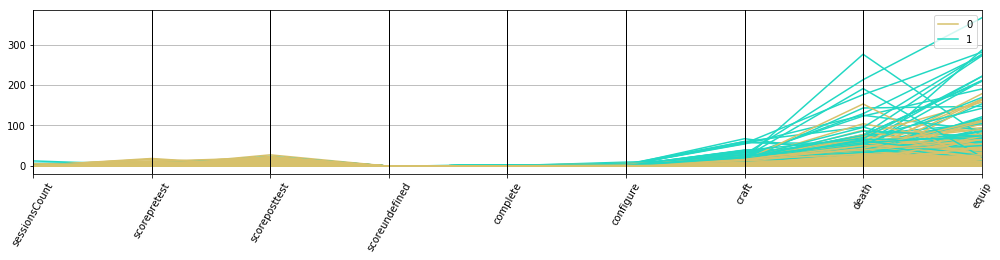

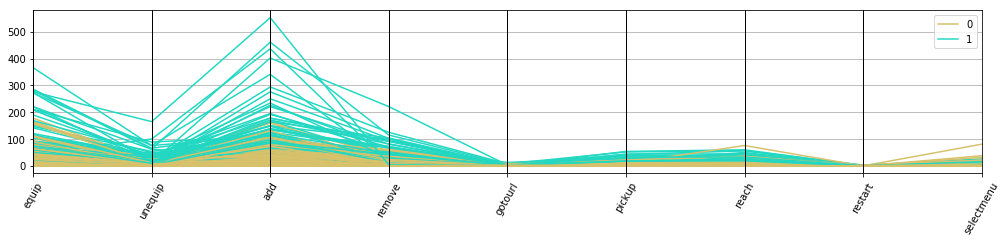

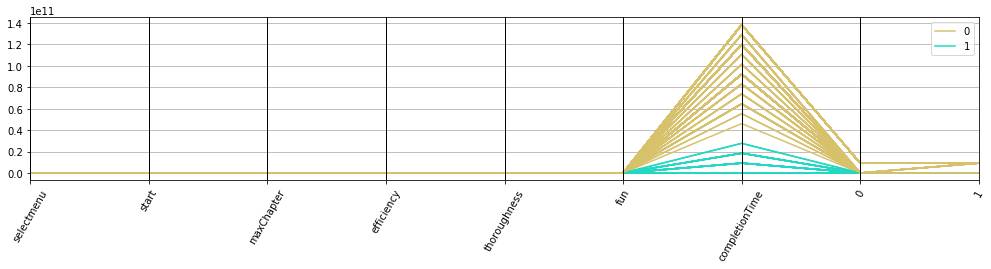

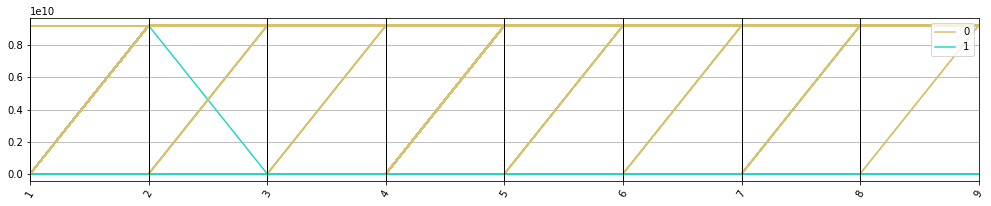

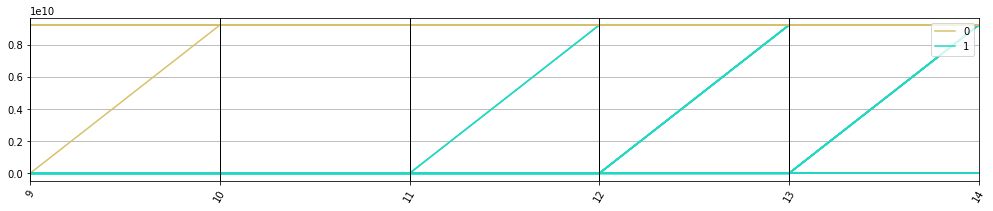

In [154]:
assignements = detailsKmeans(allData, allDataResults, 2, displayParallelCoord=True)

TODO Raphaeal : Check in details, Maybe check sub-divisions of clusters?

## Only sessions where the player has answered the questionnaire before and after playing

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


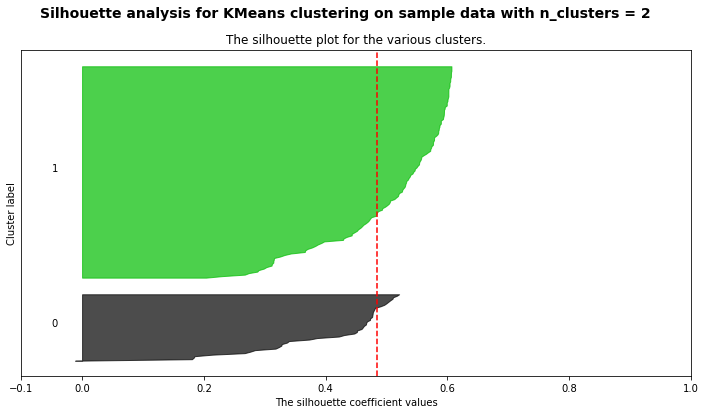

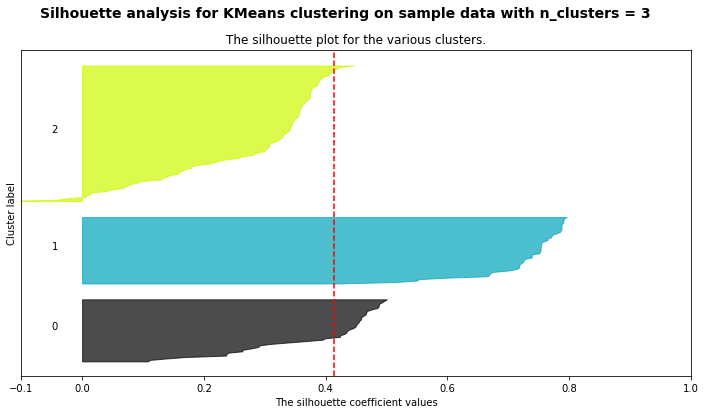

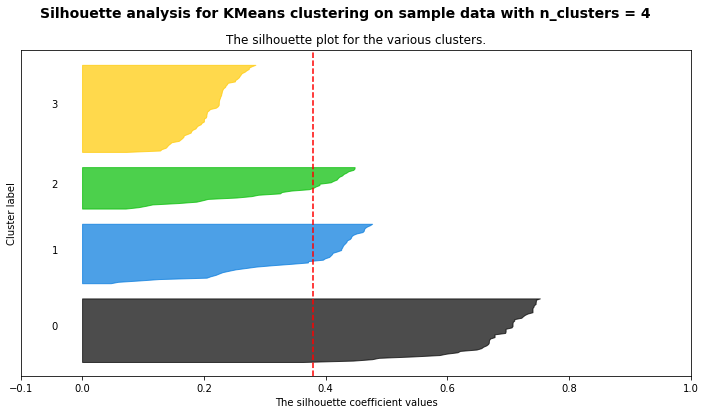

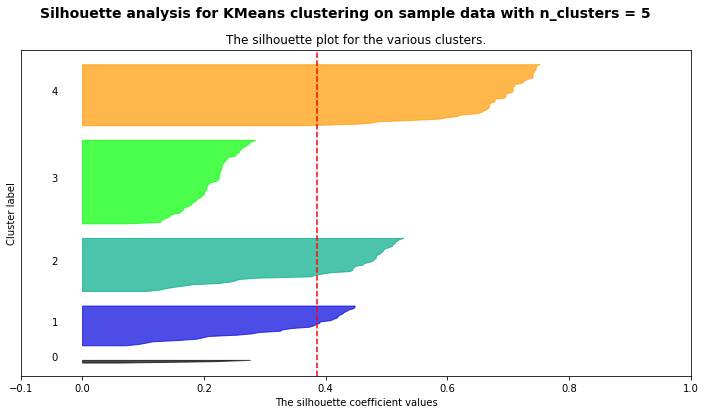

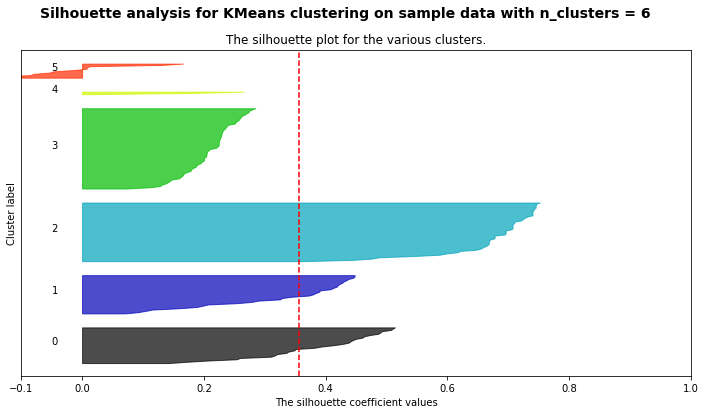

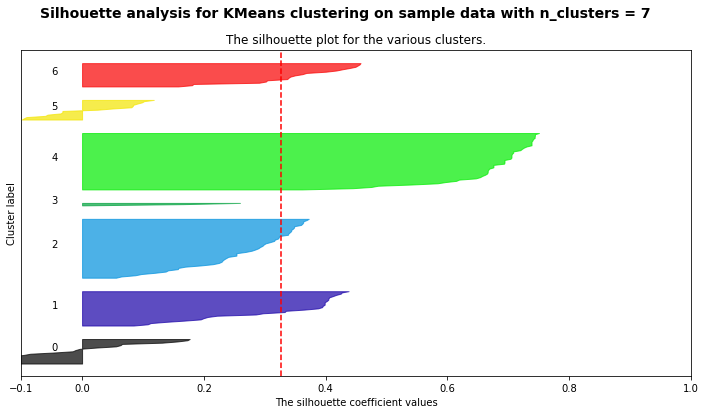

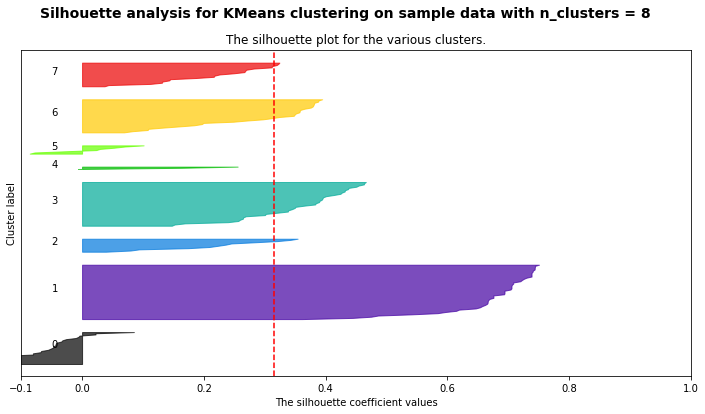

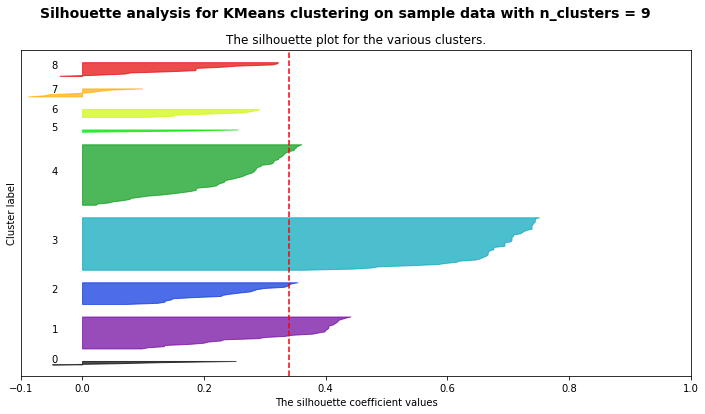

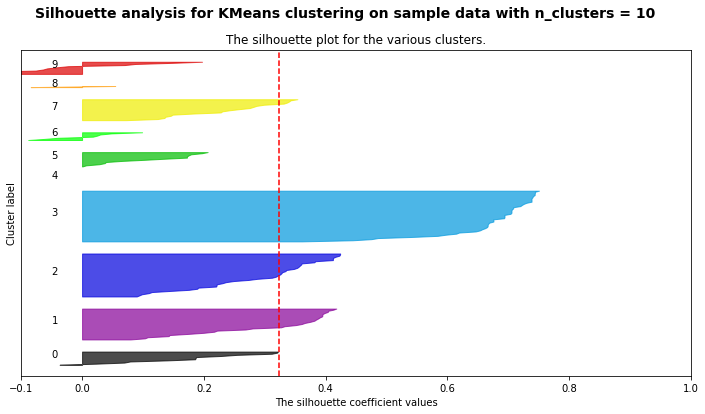

Number of clusters  Average silhouette score  \
0                   2                  0.484145   
1                   3                  0.414140   
2                   4                  0.379450   
3                   5                  0.385837   
4                   6                  0.355864   
5                   7                  0.326714   
6                   8                  0.315691   
7                   9                  0.340285   
8                  10                  0.323335   

                                     Size of cluster  \
0                                    {1: 141, 0: 45}   
1                              {1: 47, 2: 95, 0: 44}   
2                       {0: 47, 3: 64, 1: 44, 2: 31}   
3                 {4: 47, 3: 64, 2: 41, 1: 31, 0: 3}   
4          {2: 47, 3: 64, 0: 29, 1: 31, 4: 3, 5: 12}   
5   {4: 47, 5: 17, 6: 20, 1: 29, 3: 3, 2: 49, 0: 21}   
6  {1: 47, 0: 28, 7: 21, 6: 29, 4: 3, 3: 38, 2: 1...   
7  {3: 47, 0: 4, 2: 20, 1: 29, 5: 3, 4: 54, 8: 13...   
8  {3: 47, 9: 12, 7: 20, 1: 29, 8: 2, 2: 40, 0: 1...   

                                  Label assignements  
0  [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...  
1  [1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, ...  
2  [0, 3, 1, 2, 1, 1, 3, 3, 1, 1, 3, 0, 2, 2, 1, ...  
3  [4, 3, 2, 1, 0, 2, 3, 3, 2, 2, 3, 4, 1, 1, 2, ...  
4  [2, 3, 0, 1, 4, 0, 3, 3, 0, 0, 3, 2, 1, 1, 0, ...  
5  [4, 5, 6, 1, 3, 6, 2, 2, 0, 0, 2, 4, 1, 2, 6, ...  
6  [1, 0, 7, 6, 4, 7, 3, 0, 2, 2, 3, 1, 6, 3, 7, ...  
7  [3, 0, 2, 1, 5, 2, 4, 4, 8, 8, 4, 3, 1, 4, 2, ...  
8  [3, 9, 7, 1, 8, 7, 2, 2, 0, 0, 2, 3, 1, 2, 7, ...

In [155]:
# Convert DataFrame to matrix
fullProcessDataMat = fullProcessData.as_matrix()
# Standardise the data
fullProcessDataMat = preprocessing.scale(fullProcessDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
fullProcessDataResults = tryKmeans(fullProcessDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
fullProcessDataResults = pd.DataFrame(data=fullProcessDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
fullProcessDataResults

Conclusion: The data can be clustered in two groups or three groups (29/05/18)

Will split columns into 5 groups


A Jupyter Widget

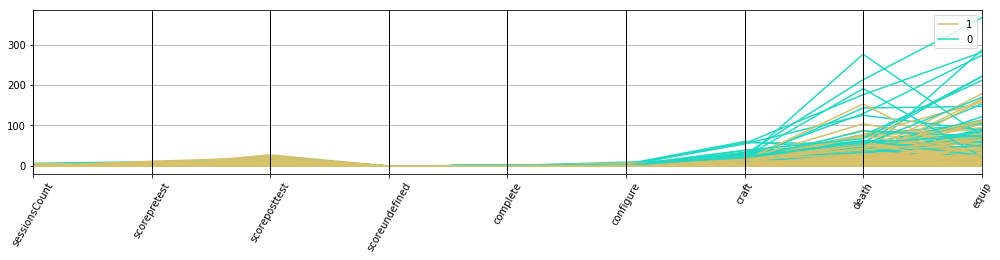

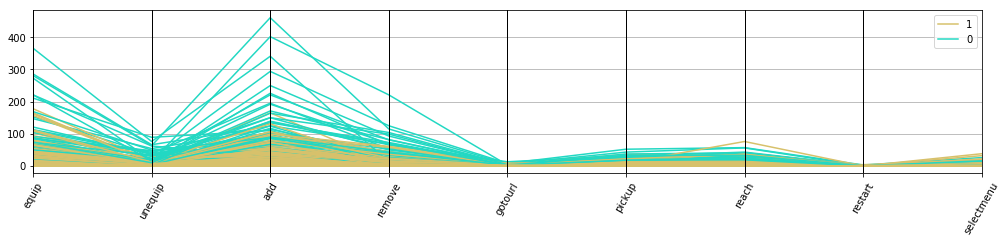

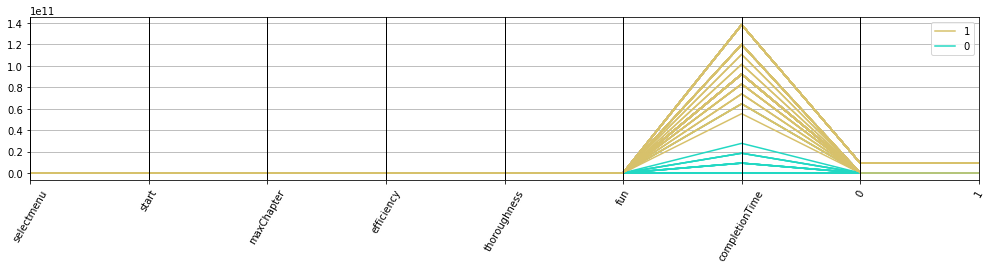

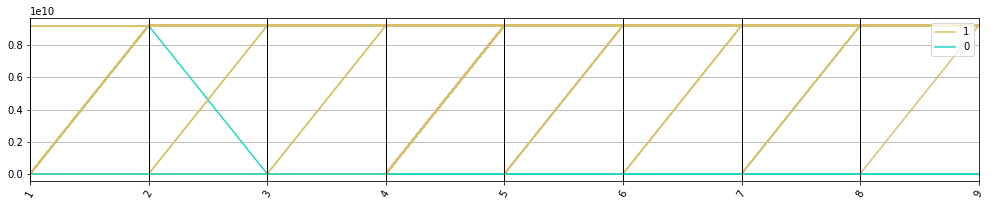

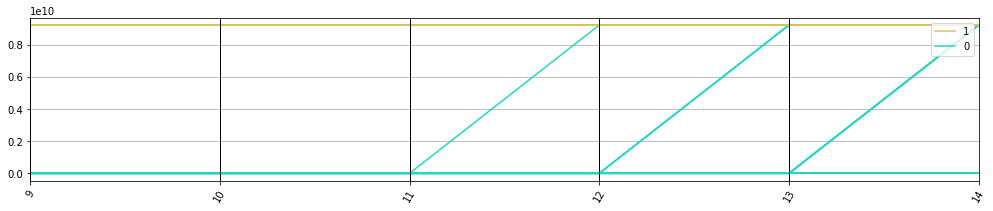

In [156]:
assignements = detailsKmeans(fullProcessData, fullProcessDataResults, 2, displayParallelCoord=True)

In [159]:
# Compute frequency of different levels of scores for each group
scores_before = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scorepretest")
scores_after = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scoreposttest")

Ttest_indResult(statistic=0.7713253426715303, pvalue=0.4415035129202268)
Ttest_indResult(statistic=7.641394879430806, pvalue=1.1446968218568233e-12)


In [158]:
# Compare groups for behaviors
freqByCluster(fullProcessData, fullProcessDataResults, 2, "configure")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "craft")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "equip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "death")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "add")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "unequip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "remove")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "pickup")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "reach")

Ttest_indResult(statistic=1.5034351839586695, pvalue=0.13444128008715628)
Ttest_indResult(statistic=13.787114264607284, pvalue=3.662221951607494e-30)
Ttest_indResult(statistic=7.163225309664772, pvalue=1.835128259516948e-11)
Ttest_indResult(statistic=8.538846650008246, pvalue=5.009774199878602e-15)
Ttest_indResult(statistic=11.924707111381224, pvalue=1.1725885975091411e-24)
Ttest_indResult(statistic=9.495087844823319, pvalue=1.1834342666218175e-17)
Ttest_indResult(statistic=11.81055990360085, pvalue=2.5391986896716763e-24)
Ttest_indResult(statistic=13.652317236313912, pvalue=9.179763087678239e-30)
Ttest_indResult(statistic=11.415482309445666, pvalue=3.653969756124376e-23)


Cluster 0  Cluster 1
0.0    0.000000   0.340426
2.0    0.000000   0.134752
3.0    0.000000   0.007092
4.0    0.000000   0.042553
5.0    0.000000   0.070922
6.0    0.000000   0.021277
7.0    0.000000   0.056738
8.0    0.000000   0.021277
9.0    0.000000   0.049645
10.0   0.000000   0.014184
11.0   0.000000   0.035461
12.0   0.000000   0.028369
13.0   0.000000   0.021277
14.0   0.000000   0.021277
15.0   0.000000   0.014184
16.0   0.000000   0.007092
17.0   0.088889   0.007092
18.0   0.022222   0.000000
19.0   0.088889   0.035461
20.0   0.133333   0.000000
21.0   0.044444   0.000000
22.0   0.111111   0.014184
23.0   0.044444   0.014184
24.0   0.044444   0.000000
25.0   0.044444   0.000000
26.0   0.022222   0.000000
28.0   0.022222   0.000000
29.0   0.022222   0.007092
30.0   0.022222   0.000000
31.0   0.044444   0.000000
33.0   0.044444   0.000000
34.0   0.066667   0.000000
36.0   0.022222   0.007092
38.0   0.000000   0.014184
39.0   0.000000   0.007092
41.0   0.044444   0.000000
43.0   0.022222   0.000000
56.0   0.022222   0.000000
57.0   0.022222   0.000000
76.0   0.000000   0.007092

Conclusion: Clusters in two groups with different behaviours and scores! (29/05/18)
TODO RAPHAEL: Check clusters (2 groups and 3 clusters)

# Can the data be clustered according to the RedMetrics and the answers to the after questionnaire?

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


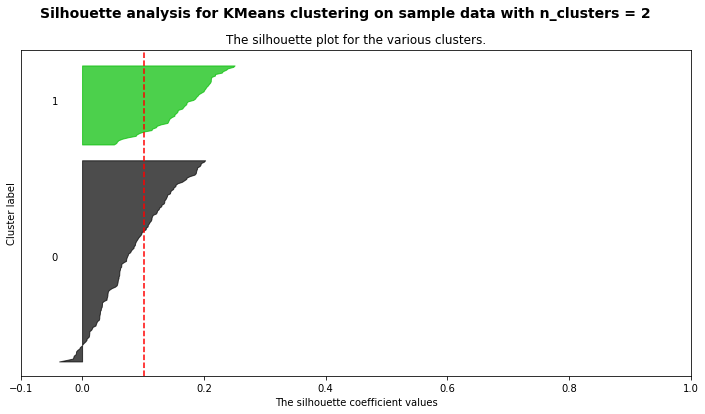

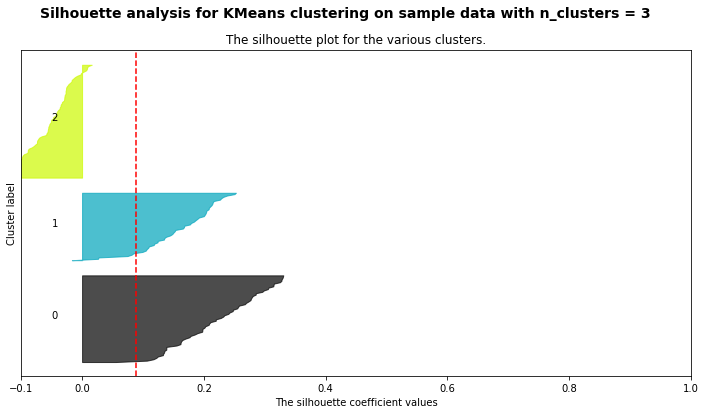

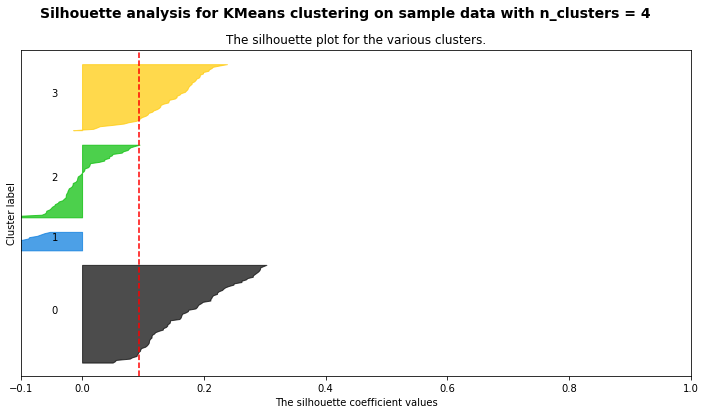

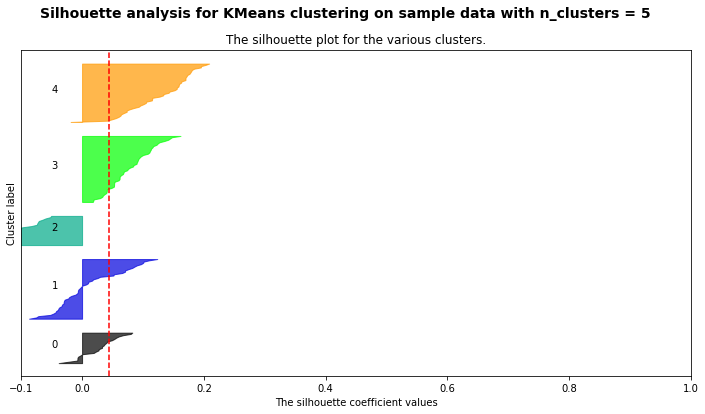

In [160]:
# Convert DataFrame to matrix
gameAndAfterMat = gameAndAfterData.as_matrix()
# Standardise the data
gameAndAfterMat = preprocessing.scale(gameAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndAfterResults = tryKmeans(gameAndAfterMat)
# Format results as a DataFrame
gameAndAfterResults = pd.DataFrame(data=gameAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: Two-clustering (29/05/18)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


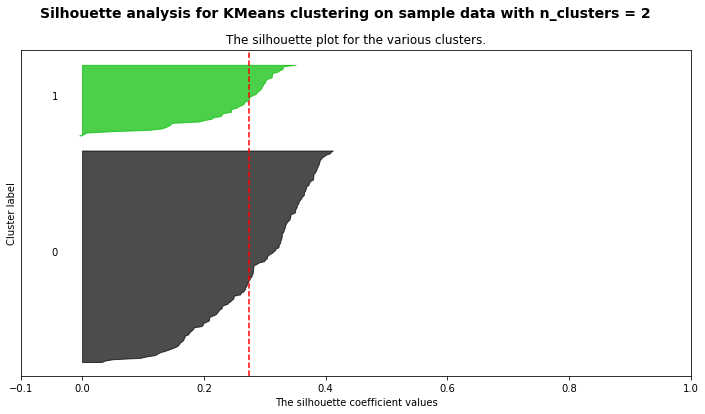

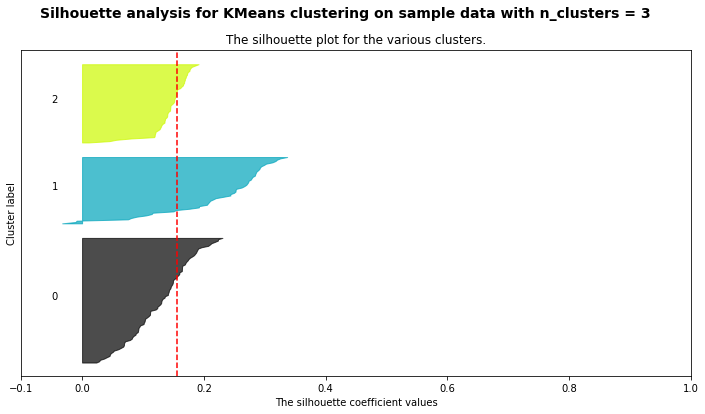

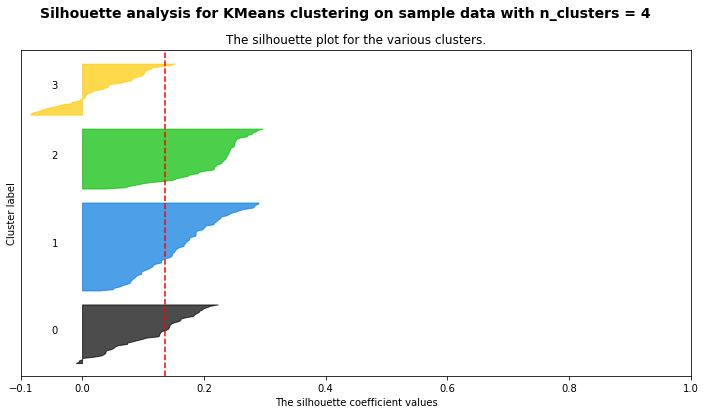

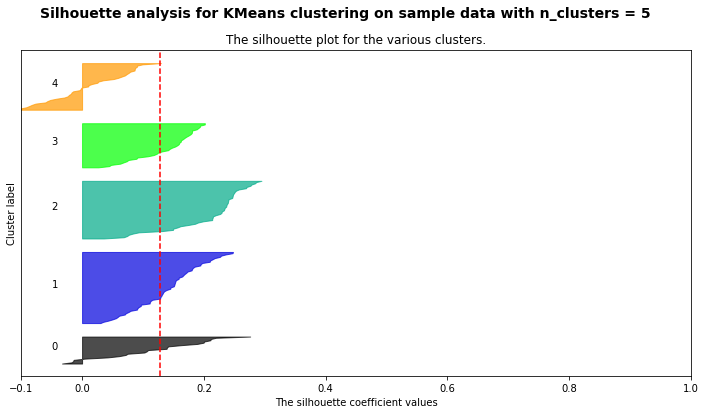

In [176]:
# Convert DataFrame to matrix
gameAndCorrectedAfterMat = gameAndCorrectedAfterData.as_matrix()
# Standardise the data
gameAndCorrectedAfterMat = preprocessing.scale(gameAndCorrectedAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndCorrectedAfterResults = tryKmeans(gameAndCorrectedAfterMat)
# Format results as a DataFrame
gameAndCorrectedAfterResults = pd.DataFrame(data=gameAndCorrectedAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (19/12/2017)

In [177]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "allScience")
correctAnswersByCluster

Cluster 0  Cluster 1
QGenotypePhenotype             0.707792   0.980769
QBioBricksDevicesComposition   0.448052   0.807692
QAmpicillin                    0.487013   0.788462
QBBNamePlasmid                 0.253247   0.461538
QBBFunctionTER                 0.318182   0.653846
QBBNamePromoter                0.220779   0.288462
QBBFunctionGameCDS             0.110390   0.365385
QBBNameTerminator              0.415584   0.673077
QBBFunctionBiologyCDS          0.142857   0.269231
QBBNameRBS                     0.142857   0.211538
QBBExampleCDS                  0.201299   0.500000
QBBNameCDS                     0.162338   0.307692
QBBFunctionPR                  0.084416   0.115385
QBBFunctionRBS                 0.259740   0.711538
QBBFunctionPLASMID             0.240260   0.730769
QBBNameOperator                0.071429   0.096154
QDeviceRbsPconsFlhdcTer        0.454545   0.961538
QDevicePconsRbsFlhdcTer        0.259740   0.596154
QDevicePbadRbsGfpTer           0.162338   0.442308
QDevicePbadGfpTbsTer           0.220779   0.596154
QDeviceGfpRbsPconsTer          0.344156   0.865385
QDevicePconsGfpRbsTer          0.201299   0.538462
QDeviceAmprRbsPconsTer         0.318182   0.865385
QDeviceRbsPconsAmprTer         0.324675   0.903846
QGreenFluorescence             0.532468   0.865385
QUnequipDevice                 0.461039   0.826923
QDevicePbadRbsAraTer           0.103896   0.211538

In [178]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=-4.889598573500906, pvalue=1.0121651386412457e-05)

In [179]:
# Compute score and compare clusters
gameAndCorrectedAfterData["sum"] = gameAndCorrectedAfterData.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=-8.747036114913229, pvalue=8.21673311262418e-16)


Cluster 0  Cluster 1
0.0    0.097403   0.000000
1.0    0.064935   0.000000
2.0    0.071429   0.019231
3.0    0.051948   0.000000
4.0    0.084416   0.000000
5.0    0.071429   0.019231
6.0    0.064935   0.019231
7.0    0.071429   0.000000
8.0    0.038961   0.000000
9.0    0.051948   0.019231
10.0   0.045455   0.019231
11.0   0.032468   0.019231
12.0   0.032468   0.096154
13.0   0.032468   0.115385
14.0   0.045455   0.019231
15.0   0.019481   0.076923
16.0   0.032468   0.057692
17.0   0.012987   0.096154
18.0   0.012987   0.173077
19.0   0.019481   0.096154
20.0   0.012987   0.076923
21.0   0.012987   0.019231
22.0   0.000000   0.038462
23.0   0.006494   0.019231
26.0   0.006494   0.000000
27.0   0.006494   0.000000

In [184]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityVideoGames")
correctAnswersByCluster

Ttest_indResult(statistic=-3.554795694977664, pvalue=0.000470076339513538)


Cluster 0  Cluster 1
1   0.097403   0.000000
2   0.175325   0.076923
3   0.201299   0.230769
4   0.298701   0.230769
5   0.227273   0.461538

In [186]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityBiology")
correctAnswersByCluster

Ttest_indResult(statistic=-2.911410767732738, pvalue=0.003998084921959244)


Cluster 0  Cluster 1
1   0.084416   0.000000
2   0.201299   0.076923
3   0.292208   0.384615
4   0.318182   0.346154
5   0.103896   0.192308

In [187]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameInterest")
correctAnswersByCluster

Ttest_indResult(statistic=-3.2943275154313376, pvalue=0.001163142432233806)


Cluster 0  Cluster 1
1   0.103896   0.000000
2   0.181818   0.115385
3   0.207792   0.134615
4   0.246753   0.346154
5   0.259740   0.403846

In [190]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QEnjoyed")
correctAnswersByCluster

Ttest_indResult(statistic=-5.4758150713549245, pvalue=1.272318871291923e-07)


Cluster 0  Cluster 1
-1   0.012987   0.000000
 0   0.129870   0.000000
 1   0.201299   0.038462
 2   0.383117   0.346154
 3   0.246753   0.519231
 4   0.025974   0.096154

In [193]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriositySyntheticBiology")
correctAnswersByCluster

Ttest_indResult(statistic=-3.878725552777076, pvalue=0.00014163376130917632)


Cluster 0  Cluster 1
1   0.123377   0.038462
2   0.233766   0.076923
3   0.311688   0.365385
4   0.259740   0.269231
5   0.071429   0.250000

In [194]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityEngineering")
correctAnswersByCluster

Ttest_indResult(statistic=-4.605708832944935, pvalue=7.229106857080919e-06)


Cluster 0  Cluster 1
1   0.136364   0.019231
2   0.207792   0.096154
3   0.279221   0.211538
4   0.240260   0.288462
5   0.136364   0.384615

In [196]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameFrequency")
correctAnswersByCluster

Ttest_indResult(statistic=-2.7402986627234323, pvalue=0.0066826972544465285)


Cluster 0  Cluster 1
1   0.136364   0.057692
2   0.201299   0.096154
3   0.266234   0.192308
4   0.175325   0.384615
5   0.220779   0.269231

In [197]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QVolunteer")
correctAnswersByCluster

Ttest_indResult(statistic=-4.074191119862391, pvalue=6.609624427216562e-05)


Cluster 0  Cluster 1
0    0.38961   0.096154
1    0.61039   0.903846

In [198]:
# Compare groups for behaviors
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "configure")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "craft")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "equip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "death")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "add")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "unequip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "remove")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "pickup")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "reach")

Ttest_indResult(statistic=-2.2373015326379053, pvalue=0.026348327264834135)
Ttest_indResult(statistic=-14.343881491688544, pvalue=9.99521303337558e-33)
Ttest_indResult(statistic=-7.534740206213249, pvalue=1.5631057725149384e-12)
Ttest_indResult(statistic=-9.37170029109791, pvalue=1.386060312791017e-17)
Ttest_indResult(statistic=-12.578900463595266, pvalue=3.0887687724101258e-27)
Ttest_indResult(statistic=-9.925915704840092, pvalue=3.3942446410709703e-19)
Ttest_indResult(statistic=-13.013244807690784, pvalue=1.3894249187406842e-28)
Ttest_indResult(statistic=-14.673164044337113, pvalue=9.417029585535208e-34)
Ttest_indResult(statistic=-12.784611702579758, pvalue=7.118869394198727e-28)


Cluster 0  Cluster 1
0.0    0.383117   0.000000
2.0    0.123377   0.000000
3.0    0.006494   0.000000
4.0    0.038961   0.000000
5.0    0.071429   0.000000
6.0    0.019481   0.000000
7.0    0.051948   0.000000
8.0    0.019481   0.000000
9.0    0.045455   0.000000
10.0   0.012987   0.000000
11.0   0.032468   0.000000
12.0   0.025974   0.000000
13.0   0.006494   0.038462
14.0   0.025974   0.000000
15.0   0.012987   0.000000
16.0   0.006494   0.000000
17.0   0.006494   0.076923
18.0   0.000000   0.019231
19.0   0.038961   0.076923
20.0   0.000000   0.115385
21.0   0.000000   0.038462
22.0   0.019481   0.096154
23.0   0.012987   0.038462
24.0   0.000000   0.038462
25.0   0.000000   0.038462
26.0   0.000000   0.019231
28.0   0.000000   0.019231
29.0   0.006494   0.019231
30.0   0.000000   0.019231
31.0   0.000000   0.038462
33.0   0.000000   0.038462
34.0   0.000000   0.076923
36.0   0.006494   0.038462
38.0   0.012987   0.000000
39.0   0.006494   0.000000
41.0   0.000000   0.057692
43.0   0.000000   0.019231
56.0   0.000000   0.038462
57.0   0.000000   0.038462
76.0   0.006494   0.000000

Conclusion: 2-clustering by answers and game behaviour. Biggest differences in profile are in curiosity and gaming profile, unlike when clustering on just answers where biology level is a more significant difference (29/05/18)